In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Documents/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2025/GINECOLOGIA Y OBSTETRICIA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 9 questions
Page 1, Q1 - A: Detected box: x0=68.3, y0=116.4, x1=144.5, y1=127.4
Page 1, Q1, A: Yellow pixels: 1130
Page 1, Q1, A: Total non-white pixels: 1524
Page 1, Q1, A: Yellow percentage: 74.1%


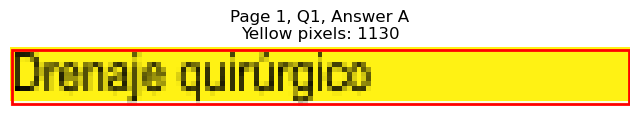

Page 1, Q1 - B: Detected box: x0=68.3, y0=129.0, x1=162.1, y1=140.0
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 485
Page 1, Q1, B: Yellow percentage: 0.0%


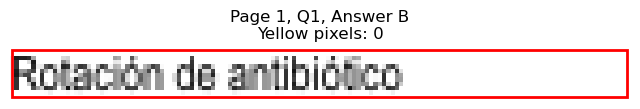

Page 1, Q1 - C: Detected box: x0=327.5, y0=116.4, x1=399.7, y1=127.4
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 363
Page 1, Q1, C: Yellow percentage: 0.0%


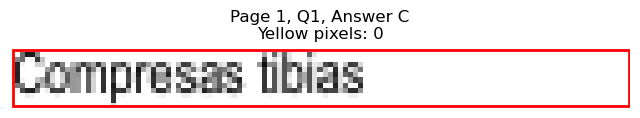

Page 1, Q1 - D: Detected box: x0=327.5, y0=129.0, x1=445.3, y1=140.0
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 587
Page 1, Q1, D: Yellow percentage: 0.0%


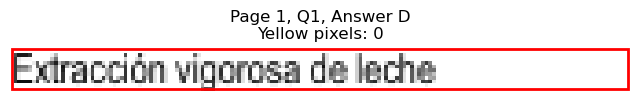


Page 1, Q1 - Selected Answer: A (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=68.3, y0=166.9, x1=95.9, y1=177.9
Page 1, Q2, A: Yellow pixels: 0
Page 1, Q2, A: Total non-white pixels: 224
Page 1, Q2, A: Yellow percentage: 0.0%


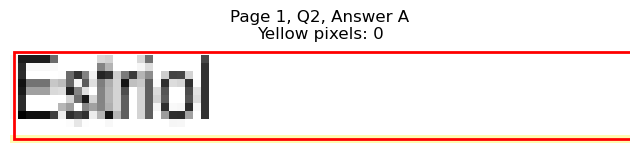

Page 1, Q2 - B: Detected box: x0=68.3, y0=179.5, x1=82.3, y1=190.5
Page 1, Q2, B: Yellow pixels: 682
Page 1, Q2, B: Total non-white pixels: 780
Page 1, Q2, B: Yellow percentage: 87.4%


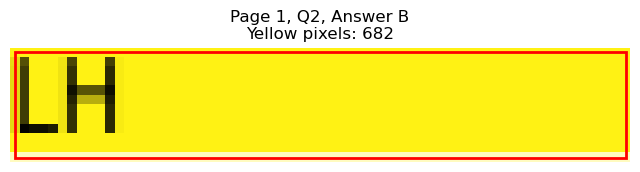

Page 1, Q2 - C: Detected box: x0=327.5, y0=166.9, x1=384.1, y1=177.9
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 287
Page 1, Q2, C: Yellow percentage: 0.0%


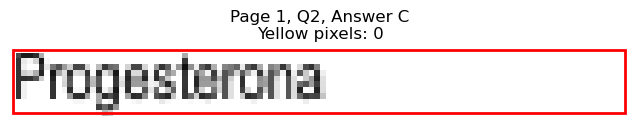

Page 1, Q2 - D: Detected box: x0=327.5, y0=179.5, x1=361.6, y1=190.5
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 190
Page 1, Q2, D: Yellow percentage: 0.0%


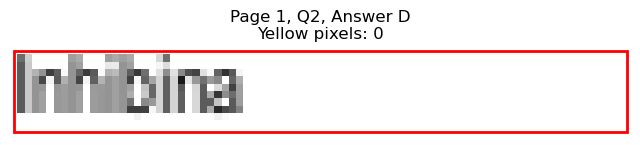


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=68.3, y0=242.6, x1=196.2, y1=253.6
Page 1, Q3, A: Yellow pixels: 1522
Page 1, Q3, A: Total non-white pixels: 2148
Page 1, Q3, A: Yellow percentage: 70.9%


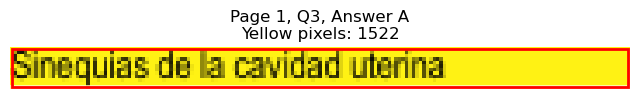

Page 1, Q3 - B: Detected box: x0=68.3, y0=255.2, x1=189.6, y1=266.2
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 618
Page 1, Q3, B: Yellow percentage: 0.0%


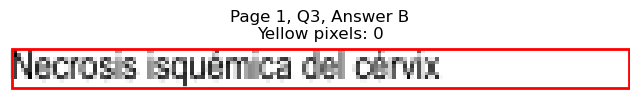

Page 1, Q3 - C: Detected box: x0=327.5, y0=242.6, x1=496.9, y1=253.6
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 882
Page 1, Q3, C: Yellow percentage: 0.0%


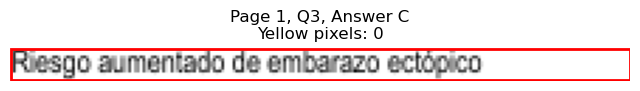

Page 1, Q3 - D: Detected box: x0=327.5, y0=255.2, x1=466.4, y1=266.2
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 681
Page 1, Q3, D: Yellow percentage: 0.0%


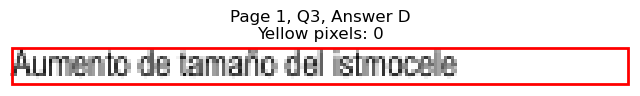


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=68.3, y0=330.9, x1=167.0, y1=342.0
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 508
Page 1, Q4, A: Yellow percentage: 0.0%


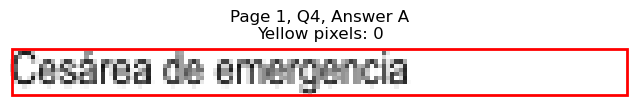

Page 1, Q4 - B: Detected box: x0=68.3, y0=343.6, x1=239.9, y1=354.7
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 884
Page 1, Q4, B: Yellow percentage: 0.0%


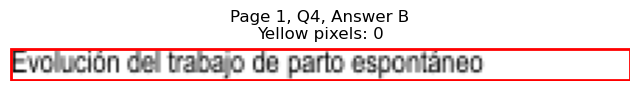

Page 1, Q4 - C: Detected box: x0=327.5, y0=330.9, x1=451.8, y1=342.0
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 814
Page 1, Q4, C: Yellow percentage: 0.0%


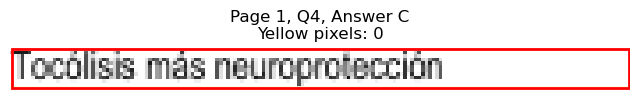

Page 1, Q4 - D: Detected box: x0=327.5, y0=343.6, x1=430.3, y1=354.7
Page 1, Q4, D: Yellow pixels: 1478
Page 1, Q4, D: Total non-white pixels: 1848
Page 1, Q4, D: Yellow percentage: 80.0%


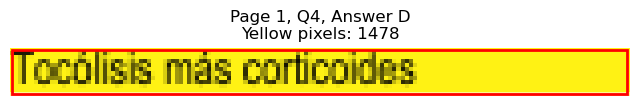


Page 1, Q4 - Selected Answer: D (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=68.3, y0=394.0, x1=92.4, y1=405.1
Page 1, Q5, A: Yellow pixels: 724
Page 1, Q5, A: Total non-white pixels: 825
Page 1, Q5, A: Yellow percentage: 87.8%


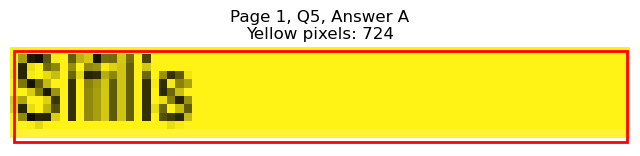

Page 1, Q5 - B: Detected box: x0=68.3, y0=406.6, x1=116.9, y1=417.7
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 241
Page 1, Q5, B: Yellow percentage: 0.0%


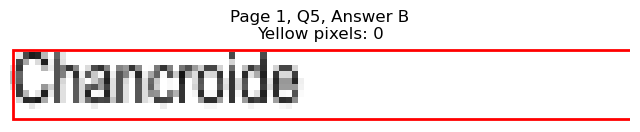

Page 1, Q5 - C: Detected box: x0=327.5, y0=394.0, x1=359.0, y1=405.1
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 164
Page 1, Q5, C: Yellow percentage: 0.0%


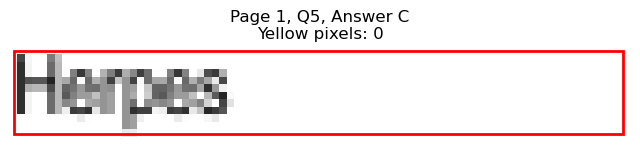

Page 1, Q5 - D: Detected box: x0=327.5, y0=406.6, x1=409.8, y1=417.7
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 425
Page 1, Q5, D: Yellow percentage: 0.0%


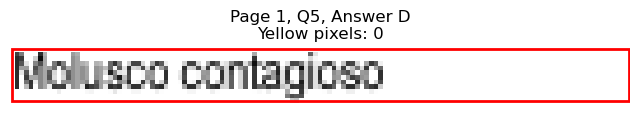


Page 1, Q5 - Selected Answer: A (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=68.3, y0=444.6, x1=316.0, y1=455.6
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 1177
Page 1, Q6, A: Yellow percentage: 0.0%


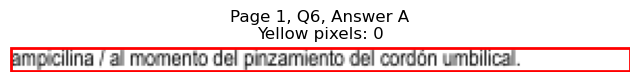

Page 1, Q6 - B: Detected box: x0=68.3, y0=457.2, x1=419.9, y1=468.2
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 1720
Page 1, Q6, B: Yellow percentage: 0.0%


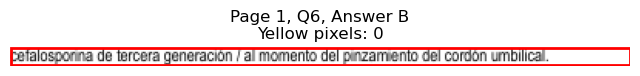

Page 1, Q6 - C: Detected box: x0=68.8, y0=469.8, x1=368.8, y1=480.8
Page 1, Q6, C: Yellow pixels: 1
Page 1, Q6, C: Total non-white pixels: 1818
Page 1, Q6, C: Yellow percentage: 0.1%


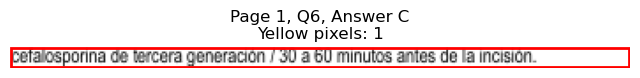

Page 1, Q6 - D: Detected box: x0=68.8, y0=482.5, x1=371.2, y1=493.5
Page 1, Q6, D: Yellow pixels: 2780
Page 1, Q6, D: Total non-white pixels: 4248
Page 1, Q6, D: Yellow percentage: 65.4%


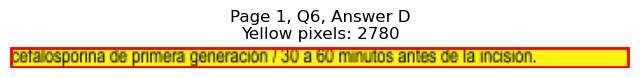


Page 1, Q6 - Selected Answer: D (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=68.3, y0=545.5, x1=173.6, y1=556.5
Page 1, Q7, A: Yellow pixels: 0
Page 1, Q7, A: Total non-white pixels: 527
Page 1, Q7, A: Yellow percentage: 0.0%


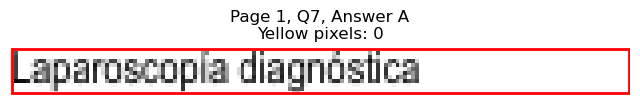

Page 1, Q7 - B: Detected box: x0=68.3, y0=558.2, x1=182.2, y1=569.2
Page 1, Q7, B: Yellow pixels: 0
Page 1, Q7, B: Total non-white pixels: 598
Page 1, Q7, B: Yellow percentage: 0.0%


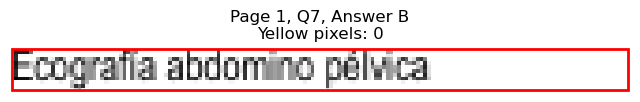

Page 1, Q7 - C: Detected box: x0=327.5, y0=545.5, x1=430.8, y1=556.5
Page 1, Q7, C: Yellow pixels: 1299
Page 1, Q7, C: Total non-white pixels: 1848
Page 1, Q7, C: Yellow percentage: 70.3%


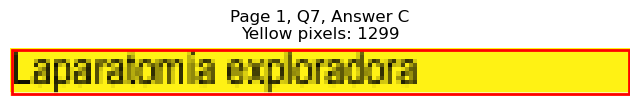

Page 1, Q7 - D: Detected box: x0=327.5, y0=558.2, x1=434.9, y1=569.2
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 549
Page 1, Q7, D: Yellow percentage: 0.0%


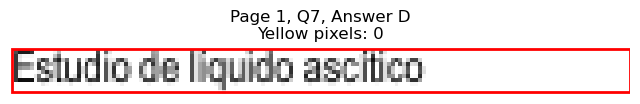


Page 1, Q7 - Selected Answer: C (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=68.3, y0=621.3, x1=136.4, y1=632.4
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 311
Page 1, Q8, A: Yellow percentage: 0.0%


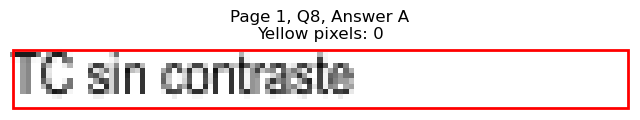

Page 1, Q8 - B: Detected box: x0=68.3, y0=633.9, x1=123.5, y1=645.0
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 294
Page 1, Q8, B: Yellow percentage: 0.0%


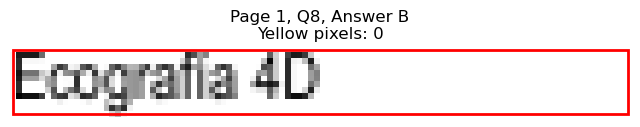

Page 1, Q8 - C: Detected box: x0=327.5, y0=621.3, x1=350.5, y1=632.4
Page 1, Q8, C: Yellow pixels: 712
Page 1, Q8, C: Total non-white pixels: 888
Page 1, Q8, C: Yellow percentage: 80.2%


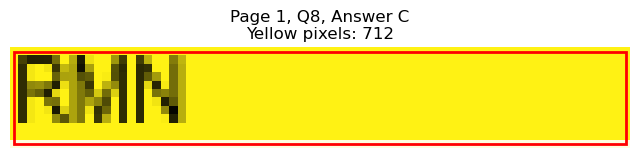

Page 1, Q8 - D: Detected box: x0=327.5, y0=633.9, x1=402.7, y1=645.0
Page 1, Q8, D: Yellow pixels: 0
Page 1, Q8, D: Total non-white pixels: 407
Page 1, Q8, D: Yellow percentage: 0.0%


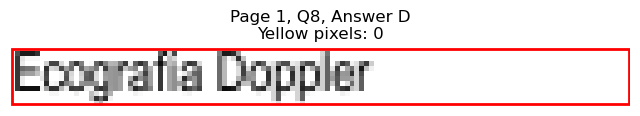


Page 1, Q8 - Selected Answer: C (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=68.3, y0=671.7, x1=216.7, y1=682.8
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 731
Page 1, Q9, A: Yellow percentage: 0.0%


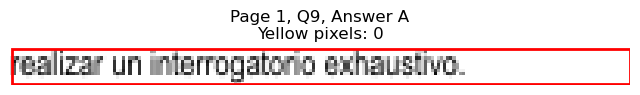

Page 1, Q9 - B: Detected box: x0=68.3, y0=684.3, x1=236.8, y1=695.4
Page 1, Q9, B: Yellow pixels: 219
Page 1, Q9, B: Total non-white pixels: 1066
Page 1, Q9, B: Yellow percentage: 20.5%


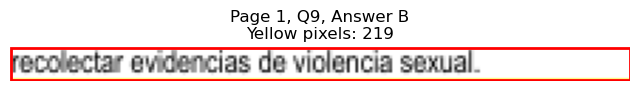

Page 1, Q9 - C: Detected box: x0=68.8, y0=697.0, x1=310.4, y1=708.1
Page 1, Q9, C: Yellow pixels: 2285
Page 1, Q9, C: Total non-white pixels: 3230
Page 1, Q9, C: Yellow percentage: 70.7%


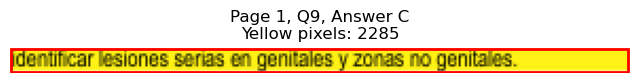

Page 1, Q9 - D: Detected box: x0=68.8, y0=709.6, x1=260.4, y1=720.7
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 942
Page 1, Q9, D: Yellow percentage: 0.0%


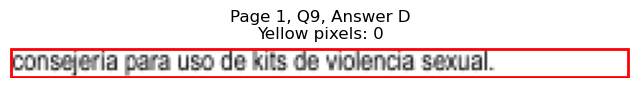


Page 1, Q9 - Selected Answer: C (based on yellow pixel count)





Page 2: Found 9 questions
Page 2, Q1 - A: Detected box: x0=68.3, y0=116.4, x1=207.7, y1=127.4
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 718
Page 2, Q1, A: Yellow percentage: 0.0%


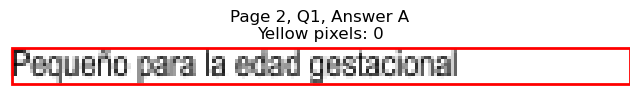

Page 2, Q1 - B: Detected box: x0=68.3, y0=129.0, x1=183.6, y1=140.0
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 574
Page 2, Q1, B: Yellow percentage: 0.0%


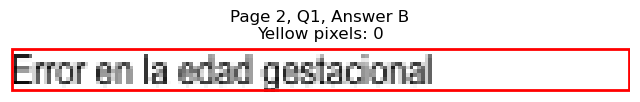

Page 2, Q1 - C: Detected box: x0=327.5, y0=116.4, x1=493.0, y1=127.4
Page 2, Q1, C: Yellow pixels: 1723
Page 2, Q1, C: Total non-white pixels: 2556
Page 2, Q1, C: Yellow percentage: 67.4%


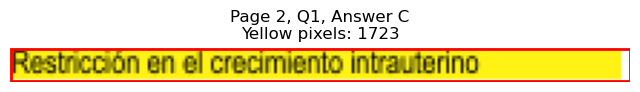

Page 2, Q1 - D: Detected box: x0=327.5, y0=129.0, x1=521.0, y1=140.0
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 971
Page 2, Q1, D: Yellow percentage: 0.0%


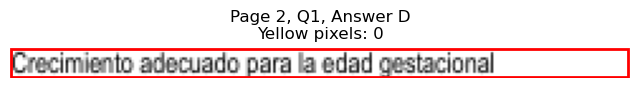


Page 2, Q1 - Selected Answer: C (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=68.3, y0=179.5, x1=209.9, y1=190.5
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 707
Page 2, Q2, A: Yellow percentage: 0.0%


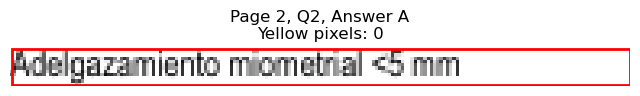

Page 2, Q2 - B: Detected box: x0=68.3, y0=192.1, x1=295.1, y1=203.1
Page 2, Q2, B: Yellow pixels: 278
Page 2, Q2, B: Total non-white pixels: 1632
Page 2, Q2, B: Yellow percentage: 17.0%


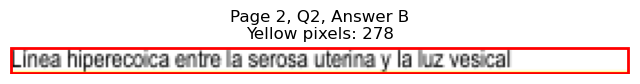

Page 2, Q2 - C: Detected box: x0=68.8, y0=204.7, x1=298.9, y1=215.7
Page 2, Q2, C: Yellow pixels: 2498
Page 2, Q2, C: Total non-white pixels: 3372
Page 2, Q2, C: Yellow percentage: 74.1%


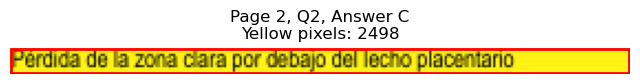

Page 2, Q2 - D: Detected box: x0=68.8, y0=217.4, x1=277.9, y1=228.4
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 1034
Page 2, Q2, D: Yellow percentage: 0.0%


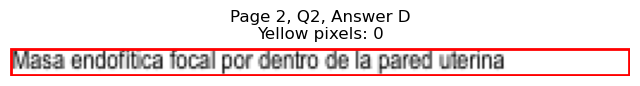


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=68.3, y0=280.5, x1=210.2, y1=291.6
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 730
Page 2, Q3, A: Yellow percentage: 0.0%


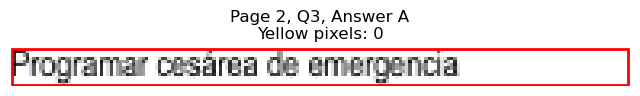

Page 2, Q3 - B: Detected box: x0=68.3, y0=293.1, x1=209.2, y1=304.2
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 703
Page 2, Q3, B: Yellow percentage: 0.0%


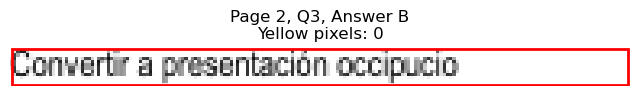

Page 2, Q3 - C: Detected box: x0=327.5, y0=280.5, x1=454.4, y1=291.6
Page 2, Q3, C: Yellow pixels: 1455
Page 2, Q3, C: Total non-white pixels: 2136
Page 2, Q3, C: Yellow percentage: 68.1%


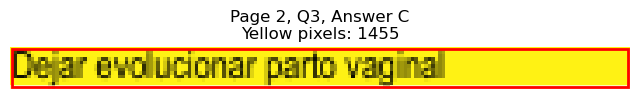

Page 2, Q3 - D: Detected box: x0=327.5, y0=293.1, x1=421.8, y1=304.2
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 458
Page 2, Q3, D: Yellow percentage: 0.0%


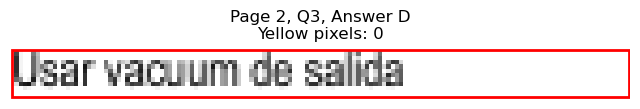


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=68.3, y0=356.2, x1=172.6, y1=367.3
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 530
Page 2, Q4, A: Yellow percentage: 0.0%


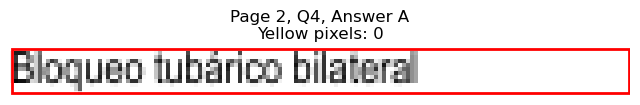

Page 2, Q4 - B: Detected box: x0=68.3, y0=368.8, x1=154.6, y1=379.9
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 424
Page 2, Q4, B: Yellow percentage: 0.0%


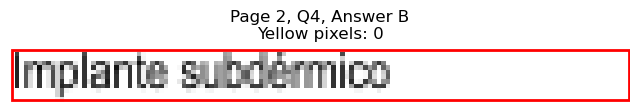

Page 2, Q4 - C: Detected box: x0=327.5, y0=356.2, x1=421.2, y1=367.3
Page 2, Q4, C: Yellow pixels: 145
Page 2, Q4, C: Total non-white pixels: 641
Page 2, Q4, C: Yellow percentage: 22.6%


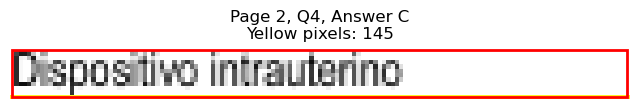

Page 2, Q4 - D: Detected box: x0=327.5, y0=368.8, x1=431.3, y1=379.9
Page 2, Q4, D: Yellow pixels: 1465
Page 2, Q4, D: Total non-white pixels: 1860
Page 2, Q4, D: Yellow percentage: 78.8%


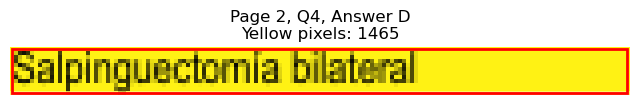


Page 2, Q4 - Selected Answer: D (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=56.6, y0=432.0, x1=65.2, y1=443.0
Page 2, Q5, A: Yellow pixels: 668
Page 2, Q5, A: Total non-white pixels: 720
Page 2, Q5, A: Yellow percentage: 92.8%


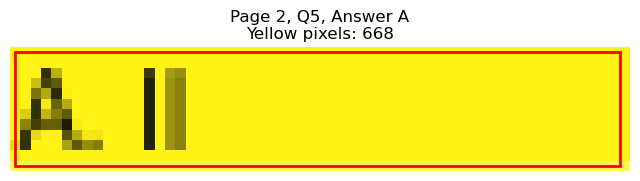

Page 2, Q5 - B: Detected box: x0=56.6, y0=444.6, x1=65.2, y1=455.6
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 50
Page 2, Q5, B: Yellow percentage: 0.0%


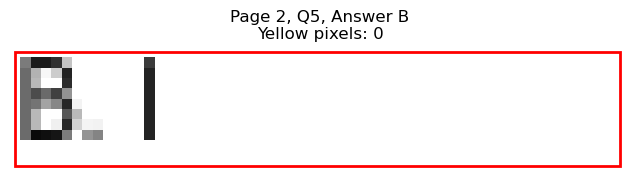

Page 2, Q5 - C: Detected box: x0=327.5, y0=432.0, x1=337.6, y1=443.0
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 48
Page 2, Q5, C: Yellow percentage: 0.0%


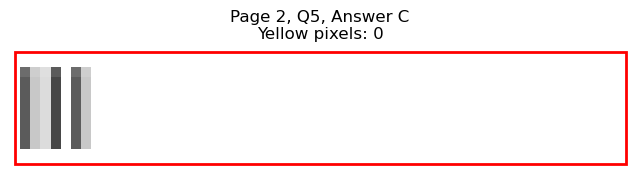

Page 2, Q5 - D: Detected box: x0=327.5, y0=444.6, x1=338.5, y1=455.6
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 43
Page 2, Q5, D: Yellow percentage: 0.0%


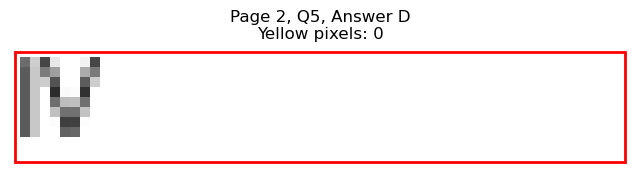


Page 2, Q5 - Selected Answer: A (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=68.3, y0=482.5, x1=155.0, y1=493.5
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 435
Page 2, Q6, A: Yellow percentage: 0.0%


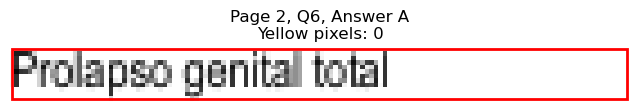

Page 2, Q6 - B: Detected box: x0=68.3, y0=495.1, x1=196.2, y1=506.1
Page 2, Q6, B: Yellow pixels: 0
Page 2, Q6, B: Total non-white pixels: 657
Page 2, Q6, B: Yellow percentage: 0.0%


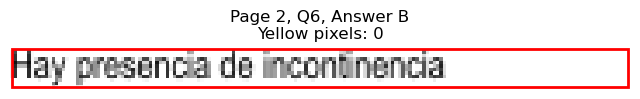

Page 2, Q6 - C: Detected box: x0=327.5, y0=482.5, x1=431.3, y1=493.5
Page 2, Q6, C: Yellow pixels: 155
Page 2, Q6, C: Total non-white pixels: 696
Page 2, Q6, C: Yellow percentage: 22.3%


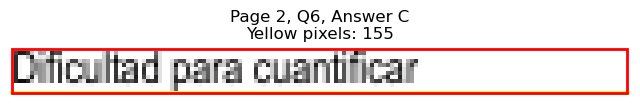

Page 2, Q6 - D: Detected box: x0=327.5, y0=495.1, x1=384.6, y1=506.1
Page 2, Q6, D: Yellow pixels: 991
Page 2, Q6, D: Total non-white pixels: 1190
Page 2, Q6, D: Yellow percentage: 83.3%


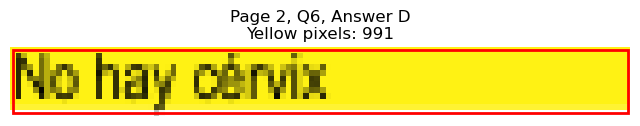


Page 2, Q6 - Selected Answer: D (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=68.3, y0=558.2, x1=124.9, y1=569.2
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 284
Page 2, Q7, A: Yellow percentage: 0.0%


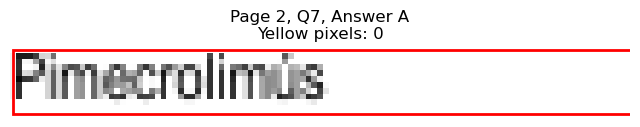

Page 2, Q7 - B: Detected box: x0=68.3, y0=570.8, x1=115.0, y1=581.8
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 216
Page 2, Q7, B: Yellow percentage: 0.0%


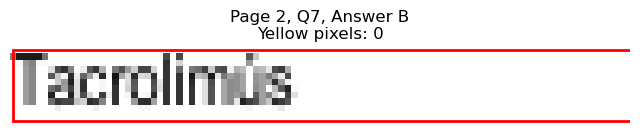

Page 2, Q7 - C: Detected box: x0=327.5, y0=558.2, x1=372.7, y1=569.2
Page 2, Q7, C: Yellow pixels: 857
Page 2, Q7, C: Total non-white pixels: 1056
Page 2, Q7, C: Yellow percentage: 81.2%


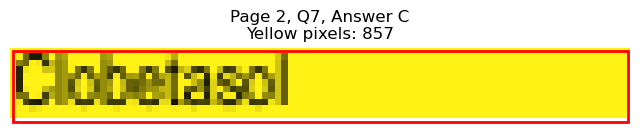

Page 2, Q7 - D: Detected box: x0=327.5, y0=570.8, x1=375.6, y1=581.8
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 251
Page 2, Q7, D: Yellow percentage: 0.0%


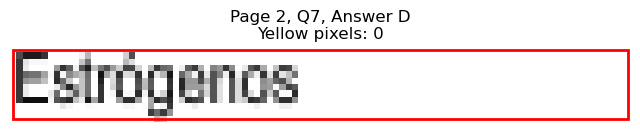


Page 2, Q7 - Selected Answer: C (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=68.3, y0=633.9, x1=173.2, y1=645.0
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 554
Page 2, Q8, A: Yellow percentage: 0.0%


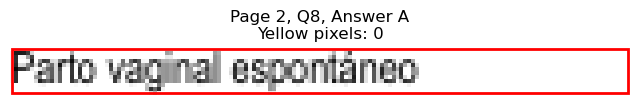

Page 2, Q8 - B: Detected box: x0=68.3, y0=646.5, x1=182.6, y1=657.6
Page 2, Q8, B: Yellow pixels: 0
Page 2, Q8, B: Total non-white pixels: 562
Page 2, Q8, B: Yellow percentage: 0.0%


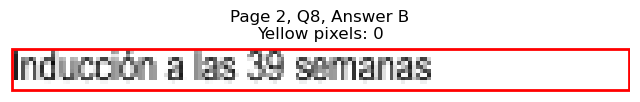

Page 2, Q8 - C: Detected box: x0=327.5, y0=633.9, x1=415.2, y1=645.0
Page 2, Q8, C: Yellow pixels: 1333
Page 2, Q8, C: Total non-white pixels: 1668
Page 2, Q8, C: Yellow percentage: 79.9%


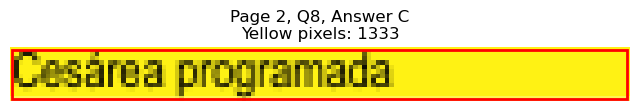

Page 2, Q8 - D: Detected box: x0=327.5, y0=646.5, x1=411.2, y1=657.6
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 404
Page 2, Q8, D: Yellow percentage: 0.0%


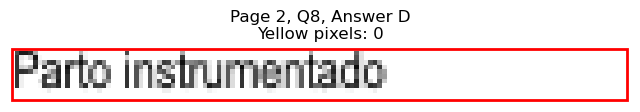


Page 2, Q8 - Selected Answer: C (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=68.3, y0=709.6, x1=137.2, y1=720.7
Page 2, Q9, A: Yellow pixels: 0
Page 2, Q9, A: Total non-white pixels: 357
Page 2, Q9, A: Yellow percentage: 0.0%


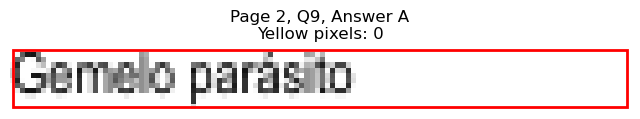

Page 2, Q9 - B: Detected box: x0=68.3, y0=722.2, x1=203.2, y1=733.3
Page 2, Q9, B: Yellow pixels: 0
Page 2, Q9, B: Total non-white pixels: 700
Page 2, Q9, B: Yellow percentage: 0.0%


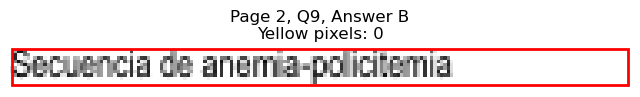

Page 2, Q9 - C: Detected box: x0=327.5, y0=709.6, x1=398.6, y1=720.7
Page 2, Q9, C: Yellow pixels: 1197
Page 2, Q9, C: Total non-white pixels: 1464
Page 2, Q9, C: Yellow percentage: 81.8%


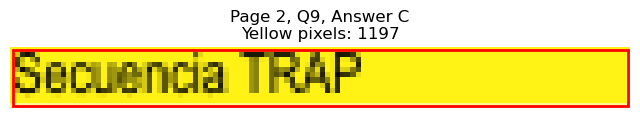

Page 2, Q9 - D: Detected box: x0=327.5, y0=722.2, x1=460.4, y1=733.3
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 675
Page 2, Q9, D: Yellow percentage: 0.0%


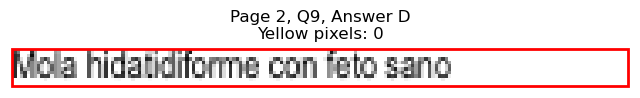


Page 2, Q9 - Selected Answer: C (based on yellow pixel count)





Page 3: Found 11 questions
Page 3, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=255.4, y1=114.8
Page 3, Q1, A: Yellow pixels: 213
Page 3, Q1, A: Total non-white pixels: 1203
Page 3, Q1, A: Yellow percentage: 17.7%


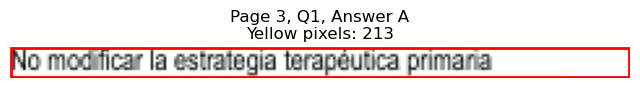

Page 3, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=200.6, y1=127.4
Page 3, Q1, B: Yellow pixels: 1489
Page 3, Q1, B: Total non-white pixels: 2196
Page 3, Q1, B: Yellow percentage: 67.8%


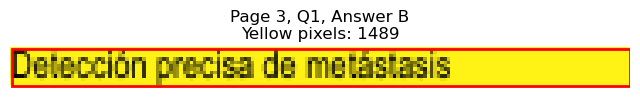

Page 3, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=466.9, y1=114.8
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 700
Page 3, Q1, C: Yellow percentage: 0.0%


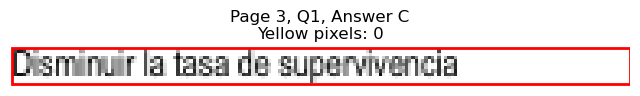

Page 3, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=449.9, y1=127.4
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 620
Page 3, Q1, D: Yellow percentage: 0.0%


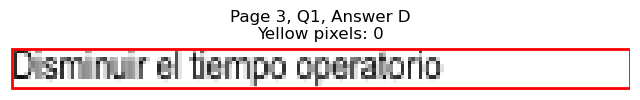


Page 3, Q1 - Selected Answer: B (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=68.3, y0=154.3, x1=199.7, y1=165.3
Page 3, Q2, A: Yellow pixels: 1533
Page 3, Q2, A: Total non-white pixels: 2184
Page 3, Q2, A: Yellow percentage: 70.2%


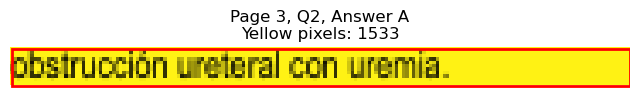

Page 3, Q2 - B: Detected box: x0=68.3, y0=166.9, x1=175.1, y1=177.9
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 514
Page 3, Q2, B: Yellow percentage: 0.0%


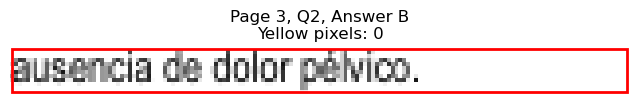

Page 3, Q2 - C: Detected box: x0=327.5, y0=154.3, x1=461.4, y1=165.3
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 650
Page 3, Q2, C: Yellow percentage: 0.0%


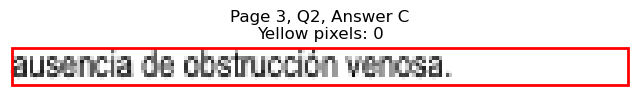

Page 3, Q2 - D: Detected box: x0=327.5, y0=166.9, x1=385.2, y1=177.9
Page 3, Q2, D: Yellow pixels: 0
Page 3, Q2, D: Total non-white pixels: 273
Page 3, Q2, D: Yellow percentage: 0.0%


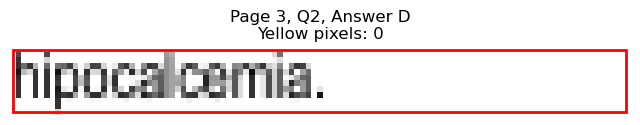


Page 3, Q2 - Selected Answer: A (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=68.3, y0=204.7, x1=270.5, y1=215.7
Page 3, Q3, A: Yellow pixels: 5
Page 3, Q3, A: Total non-white pixels: 1259
Page 3, Q3, A: Yellow percentage: 0.4%


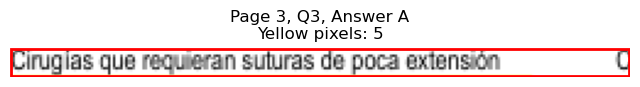

Page 3, Q3 - B: Detected box: x0=68.3, y0=217.4, x1=142.1, y1=228.4
Page 3, Q3, B: Yellow pixels: 1083
Page 3, Q3, B: Total non-white pixels: 1500
Page 3, Q3, B: Yellow percentage: 72.2%


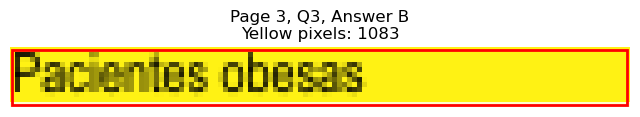

Page 3, Q3 - C: Detected box: x0=327.5, y0=204.7, x1=480.5, y1=215.7
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 776
Page 3, Q3, C: Yellow percentage: 0.0%


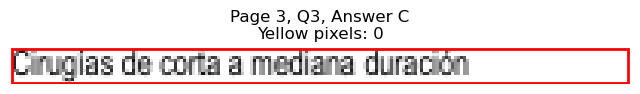

Page 3, Q3 - D: Detected box: x0=327.5, y0=217.4, x1=466.0, y1=228.4
Page 3, Q3, D: Yellow pixels: 0
Page 3, Q3, D: Total non-white pixels: 732
Page 3, Q3, D: Yellow percentage: 0.0%


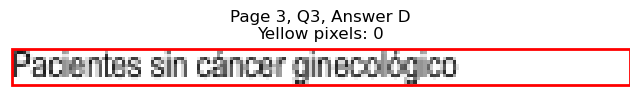


Page 3, Q3 - Selected Answer: B (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=68.3, y0=255.2, x1=175.6, y1=266.2
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 547
Page 3, Q4, A: Yellow percentage: 0.0%


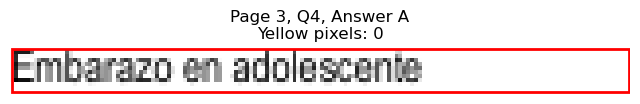

Page 3, Q4 - B: Detected box: x0=68.3, y0=267.8, x1=116.4, y1=278.8
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 286
Page 3, Q4, B: Yellow percentage: 0.0%


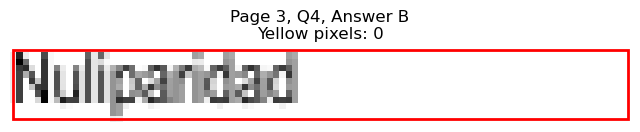

Page 3, Q4 - C: Detected box: x0=327.5, y0=255.2, x1=418.2, y1=266.2
Page 3, Q4, C: Yellow pixels: 1206
Page 3, Q4, C: Total non-white pixels: 1564
Page 3, Q4, C: Yellow percentage: 77.1%


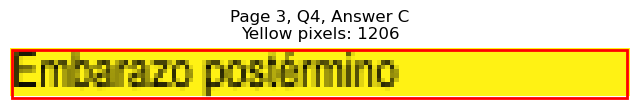

Page 3, Q4 - D: Detected box: x0=327.5, y0=267.8, x1=395.2, y1=278.8
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 344
Page 3, Q4, D: Yellow percentage: 0.0%


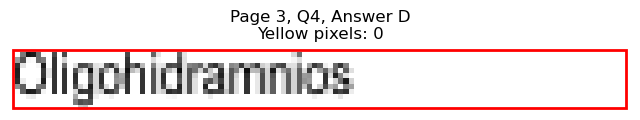


Page 3, Q4 - Selected Answer: C (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=68.3, y0=330.9, x1=83.4, y1=342.0
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 68
Page 3, Q5, A: Yellow percentage: 0.0%


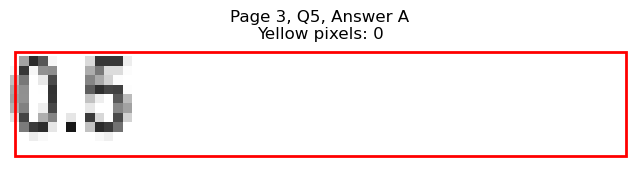

Page 3, Q5 - B: Detected box: x0=68.3, y0=343.6, x1=83.4, y1=354.7
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 70
Page 3, Q5, B: Yellow percentage: 0.0%


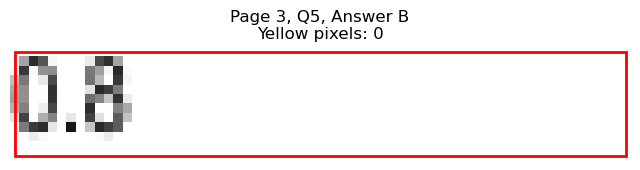

Page 3, Q5 - C: Detected box: x0=315.4, y0=330.9, x1=324.4, y1=342.0
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 124
Page 3, Q5, C: Yellow percentage: 0.0%


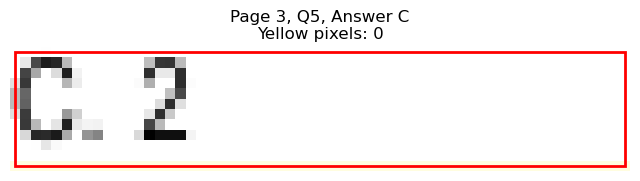

Page 3, Q5 - D: Detected box: x0=315.4, y0=343.6, x1=324.4, y1=354.7
Page 3, Q5, D: Yellow pixels: 670
Page 3, Q5, D: Total non-white pixels: 720
Page 3, Q5, D: Yellow percentage: 93.1%


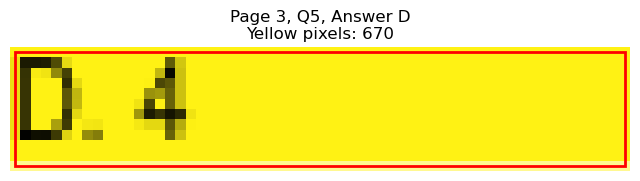


Page 3, Q5 - Selected Answer: D (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=68.3, y0=406.6, x1=135.0, y1=417.7
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 384
Page 3, Q6, A: Yellow percentage: 0.0%


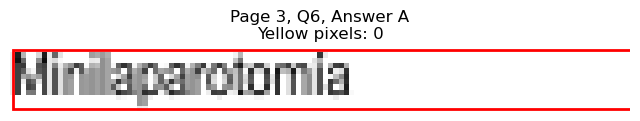

Page 3, Q6 - B: Detected box: x0=68.3, y0=419.4, x1=125.5, y1=430.4
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 290
Page 3, Q6, B: Yellow percentage: 0.0%


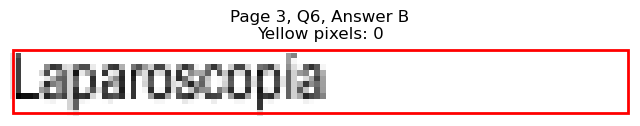

Page 3, Q6 - C: Detected box: x0=327.5, y0=406.6, x1=430.3, y1=417.7
Page 3, Q6, C: Yellow pixels: 1455
Page 3, Q6, C: Total non-white pixels: 1848
Page 3, Q6, C: Yellow percentage: 78.7%


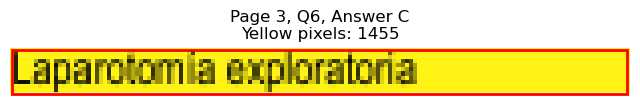

Page 3, Q6 - D: Detected box: x0=327.5, y0=419.4, x1=393.7, y1=430.4
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 345
Page 3, Q6, D: Yellow percentage: 0.0%


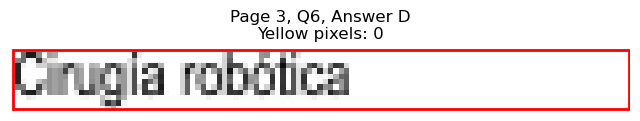


Page 3, Q6 - Selected Answer: C (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=68.3, y0=469.8, x1=133.0, y1=480.8
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 337
Page 3, Q7, A: Yellow percentage: 0.0%


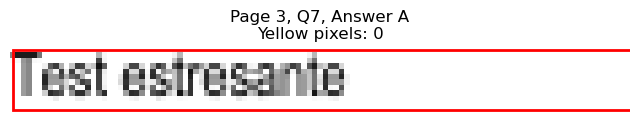

Page 3, Q7 - B: Detected box: x0=68.3, y0=482.5, x1=146.5, y1=493.5
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 421
Page 3, Q7, B: Yellow percentage: 0.0%


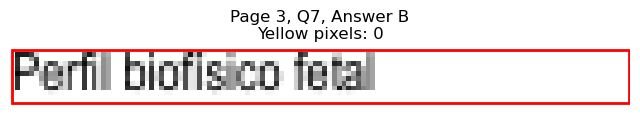

Page 3, Q7 - C: Detected box: x0=327.5, y0=469.8, x1=402.7, y1=480.8
Page 3, Q7, C: Yellow pixels: 1
Page 3, Q7, C: Total non-white pixels: 526
Page 3, Q7, C: Yellow percentage: 0.2%


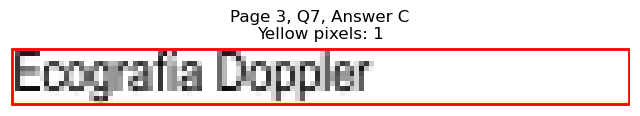

Page 3, Q7 - D: Detected box: x0=327.5, y0=482.5, x1=404.8, y1=493.5
Page 3, Q7, D: Yellow pixels: 1123
Page 3, Q7, D: Total non-white pixels: 1536
Page 3, Q7, D: Yellow percentage: 73.1%


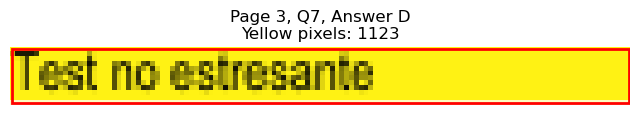


Page 3, Q7 - Selected Answer: D (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=68.3, y0=545.5, x1=107.0, y1=556.5
Page 3, Q8, A: Yellow pixels: 845
Page 3, Q8, A: Total non-white pixels: 1080
Page 3, Q8, A: Yellow percentage: 78.2%


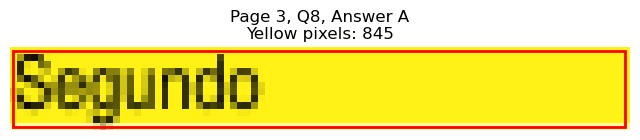

Page 3, Q8 - B: Detected box: x0=68.3, y0=558.2, x1=97.3, y1=569.2
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 146
Page 3, Q8, B: Yellow percentage: 0.0%


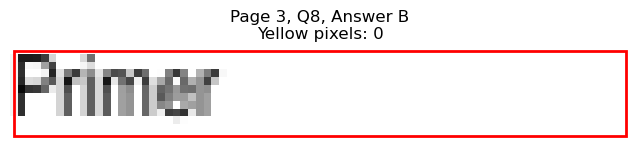

Page 3, Q8 - C: Detected box: x0=327.5, y0=545.5, x1=356.0, y1=556.5
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 132
Page 3, Q8, C: Yellow percentage: 0.0%


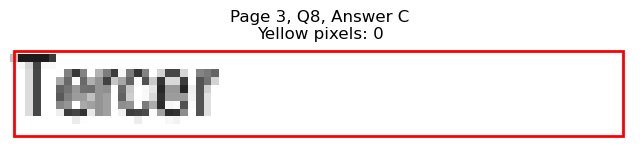

Page 3, Q8 - D: Detected box: x0=327.5, y0=558.2, x1=357.1, y1=569.2
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 151
Page 3, Q8, D: Yellow percentage: 0.0%


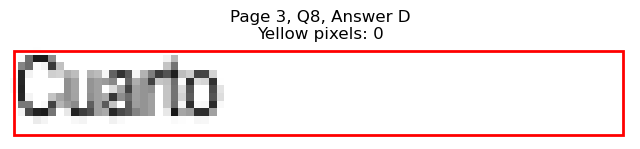


Page 3, Q8 - Selected Answer: A (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=68.3, y0=608.6, x1=129.5, y1=619.6
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 286
Page 3, Q9, A: Yellow percentage: 0.0%


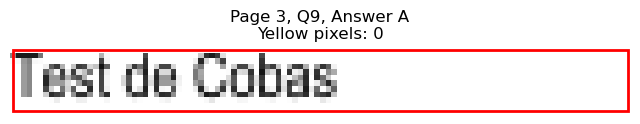

Page 3, Q9 - B: Detected box: x0=68.3, y0=621.3, x1=121.6, y1=632.4
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 278
Page 3, Q9, B: Yellow percentage: 0.0%


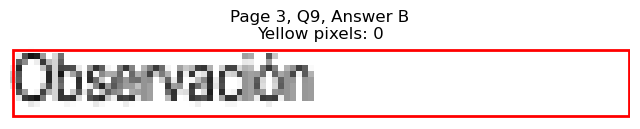

Page 3, Q9 - C: Detected box: x0=327.5, y0=608.6, x1=398.6, y1=619.6
Page 3, Q9, C: Yellow pixels: 1188
Page 3, Q9, C: Total non-white pixels: 1464
Page 3, Q9, C: Yellow percentage: 81.1%


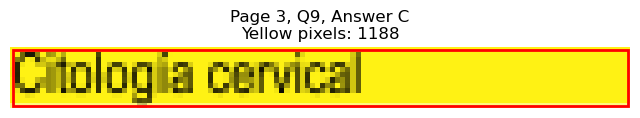

Page 3, Q9 - D: Detected box: x0=327.5, y0=621.3, x1=395.8, y1=632.4
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 333
Page 3, Q9, D: Yellow percentage: 0.0%


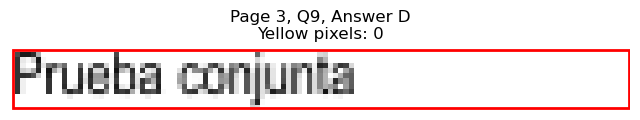


Page 3, Q9 - Selected Answer: C (based on yellow pixel count)




Page 3, Q10 - A: Detected box: x0=68.3, y0=671.7, x1=96.4, y1=682.8
Page 3, Q10, A: Yellow pixels: 79
Page 3, Q10, A: Total non-white pixels: 207
Page 3, Q10, A: Yellow percentage: 38.2%


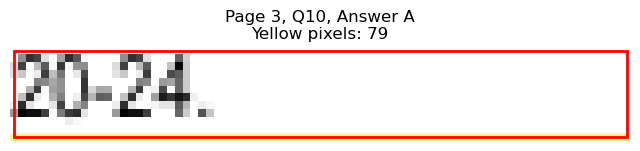

Page 3, Q10 - B: Detected box: x0=68.3, y0=684.3, x1=96.4, y1=695.4
Page 3, Q10, B: Yellow pixels: 781
Page 3, Q10, B: Total non-white pixels: 948
Page 3, Q10, B: Yellow percentage: 82.4%


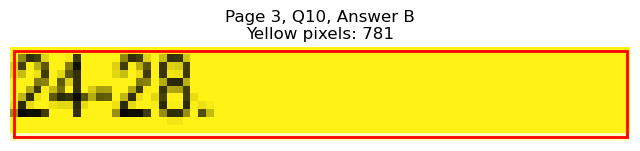

Page 3, Q10 - C: Detected box: x0=327.5, y0=671.7, x1=355.6, y1=682.8
Page 3, Q10, C: Yellow pixels: 0
Page 3, Q10, C: Total non-white pixels: 127
Page 3, Q10, C: Yellow percentage: 0.0%


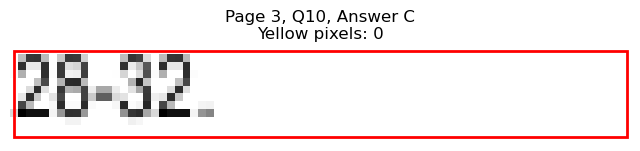

Page 3, Q10 - D: Detected box: x0=327.5, y0=684.3, x1=355.6, y1=695.4
Page 3, Q10, D: Yellow pixels: 0
Page 3, Q10, D: Total non-white pixels: 119
Page 3, Q10, D: Yellow percentage: 0.0%


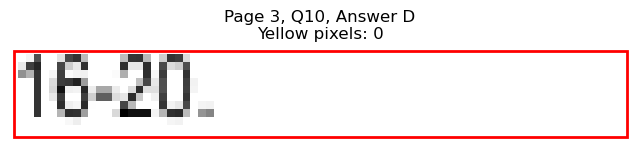


Page 3, Q10 - Selected Answer: B (based on yellow pixel count)




Page 3, Q11 - A: Detected box: x0=68.3, y0=722.2, x1=161.0, y1=733.3
Page 3, Q11, A: Yellow pixels: 0
Page 3, Q11, A: Total non-white pixels: 474
Page 3, Q11, A: Yellow percentage: 0.0%


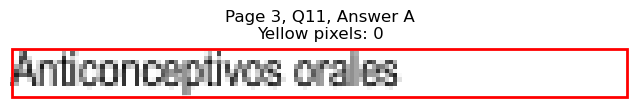

Page 3, Q11 - B: Detected box: x0=68.3, y0=734.8, x1=156.0, y1=745.9
Page 3, Q11, B: Yellow pixels: 0
Page 3, Q11, B: Total non-white pixels: 473
Page 3, Q11, B: Yellow percentage: 0.0%


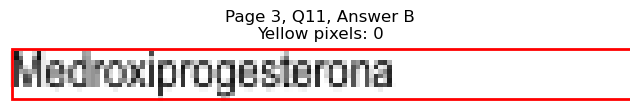

Page 3, Q11 - C: Detected box: x0=327.5, y0=722.2, x1=422.3, y1=733.3
Page 3, Q11, C: Yellow pixels: 146
Page 3, Q11, C: Total non-white pixels: 627
Page 3, Q11, C: Yellow percentage: 23.3%


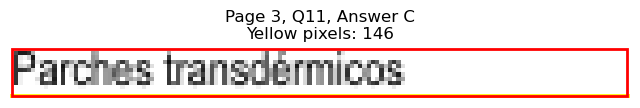

Page 3, Q11 - D: Detected box: x0=327.5, y0=734.8, x1=423.8, y1=745.9
Page 3, Q11, D: Yellow pixels: 1406
Page 3, Q11, D: Total non-white pixels: 1764
Page 3, Q11, D: Yellow percentage: 79.7%


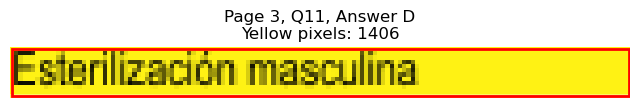


Page 3, Q11 - Selected Answer: D (based on yellow pixel count)





Page 4: Found 9 questions
Page 4, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=198.7, y1=114.8
Page 4, Q1, A: Yellow pixels: 1670
Page 4, Q1, A: Total non-white pixels: 2172
Page 4, Q1, A: Yellow percentage: 76.9%


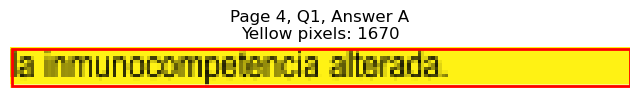

Page 4, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=119.4, y1=127.4
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 246
Page 4, Q1, B: Yellow percentage: 0.0%


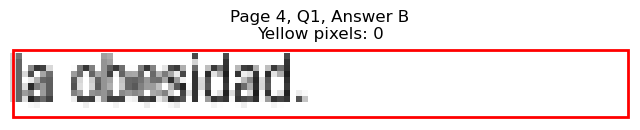

Page 4, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=460.0, y1=114.8
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 673
Page 4, Q1, C: Yellow percentage: 0.0%


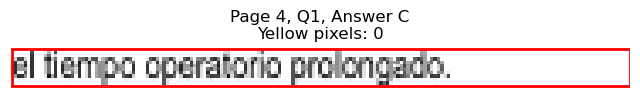

Page 4, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=477.4, y1=127.4
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 777
Page 4, Q1, D: Yellow percentage: 0.0%


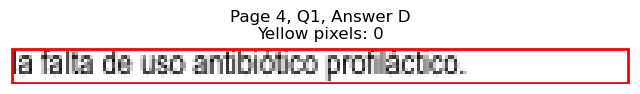


Page 4, Q1 - Selected Answer: A (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=68.3, y0=179.5, x1=91.3, y1=190.5
Page 4, Q2, A: Yellow pixels: 728
Page 4, Q2, A: Total non-white pixels: 888
Page 4, Q2, A: Yellow percentage: 82.0%


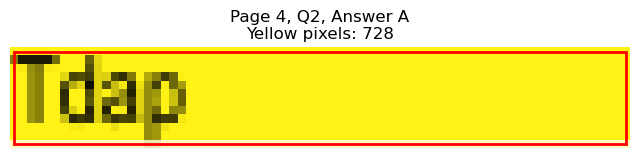

Page 4, Q2 - B: Detected box: x0=68.3, y0=192.1, x1=104.4, y1=203.1
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 198
Page 4, Q2, B: Yellow percentage: 0.0%


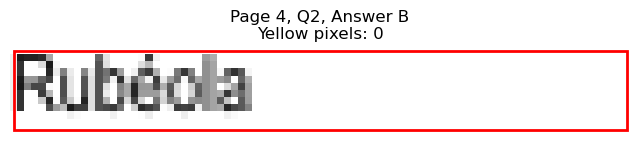

Page 4, Q2 - C: Detected box: x0=327.5, y0=179.5, x1=362.6, y1=190.5
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 170
Page 4, Q2, C: Yellow percentage: 0.0%


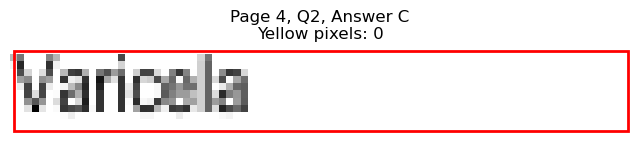

Page 4, Q2 - D: Detected box: x0=327.5, y0=192.1, x1=348.6, y1=203.1
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 96
Page 4, Q2, D: Yellow percentage: 0.0%


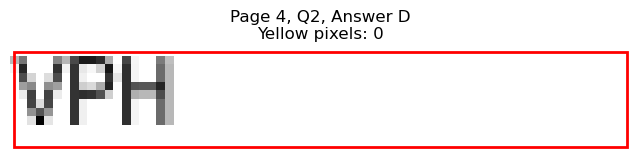


Page 4, Q2 - Selected Answer: A (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=68.3, y0=255.2, x1=187.7, y1=266.2
Page 4, Q3, A: Yellow pixels: 170
Page 4, Q3, A: Total non-white pixels: 769
Page 4, Q3, A: Yellow percentage: 22.1%


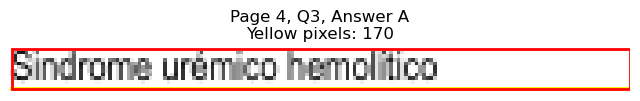

Page 4, Q3 - B: Detected box: x0=68.3, y0=267.8, x1=140.5, y1=278.8
Page 4, Q3, B: Yellow pixels: 1201
Page 4, Q3, B: Total non-white pixels: 1476
Page 4, Q3, B: Yellow percentage: 81.4%


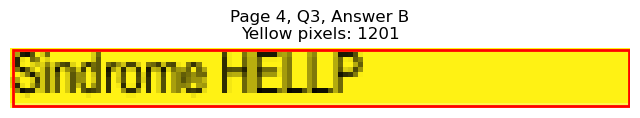

Page 4, Q3 - C: Detected box: x0=327.5, y0=255.2, x1=432.4, y1=266.2
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 568
Page 4, Q3, C: Yellow percentage: 0.0%


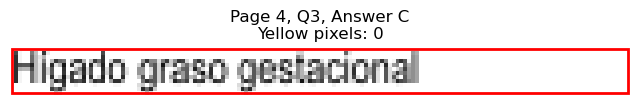

Page 4, Q3 - D: Detected box: x0=327.5, y0=267.8, x1=478.0, y1=278.8
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 736
Page 4, Q3, D: Yellow percentage: 0.0%


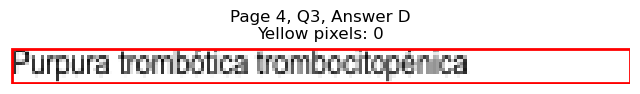


Page 4, Q3 - Selected Answer: B (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=68.3, y0=330.9, x1=129.5, y1=342.0
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 310
Page 4, Q4, A: Yellow percentage: 0.0%


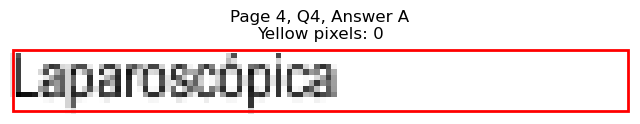

Page 4, Q4 - B: Detected box: x0=68.3, y0=343.6, x1=121.4, y1=354.7
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 267
Page 4, Q4, B: Yellow percentage: 0.0%


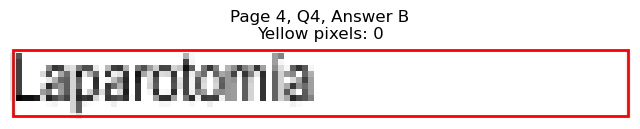

Page 4, Q4 - C: Detected box: x0=327.5, y0=330.9, x1=365.6, y1=342.0
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 288
Page 4, Q4, C: Yellow percentage: 0.0%


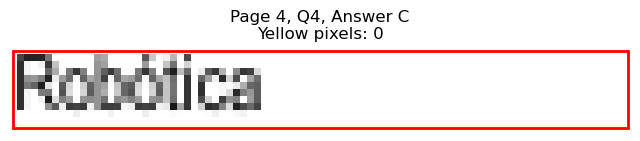

Page 4, Q4 - D: Detected box: x0=327.5, y0=343.6, x1=389.2, y1=354.7
Page 4, Q4, D: Yellow pixels: 1107
Page 4, Q4, D: Total non-white pixels: 1356
Page 4, Q4, D: Yellow percentage: 81.6%


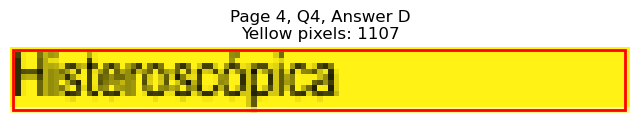


Page 4, Q4 - Selected Answer: D (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=68.3, y0=406.6, x1=114.5, y1=417.7
Page 4, Q5, A: Yellow pixels: 988
Page 4, Q5, A: Total non-white pixels: 1164
Page 4, Q5, A: Yellow percentage: 84.9%


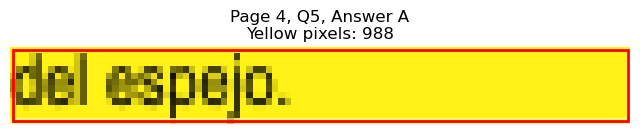

Page 4, Q5 - B: Detected box: x0=68.3, y0=419.4, x1=149.0, y1=430.4
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 402
Page 4, Q5, B: Yellow percentage: 0.0%


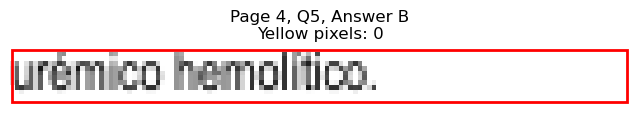

Page 4, Q5 - C: Detected box: x0=327.5, y0=406.6, x1=361.1, y1=417.7
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 145
Page 4, Q5, C: Yellow percentage: 0.0%


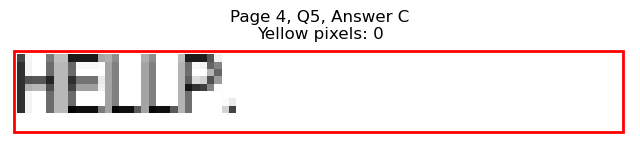

Page 4, Q5 - D: Detected box: x0=327.5, y0=419.4, x1=384.7, y1=430.4
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 254
Page 4, Q5, D: Yellow percentage: 0.0%


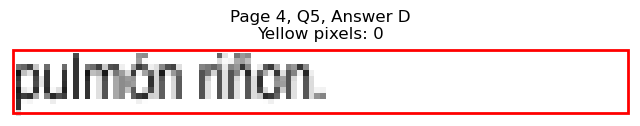


Page 4, Q5 - Selected Answer: A (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=68.3, y0=469.8, x1=80.9, y1=480.8
Page 4, Q6, A: Yellow pixels: 719
Page 4, Q6, A: Total non-white pixels: 756
Page 4, Q6, A: Yellow percentage: 95.1%


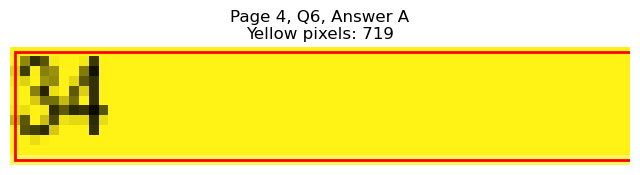

Page 4, Q6 - B: Detected box: x0=68.3, y0=482.5, x1=80.9, y1=493.5
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 67
Page 4, Q6, B: Yellow percentage: 0.0%


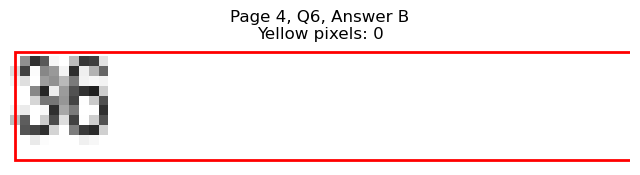

Page 4, Q6 - C: Detected box: x0=327.5, y0=469.8, x1=340.1, y1=480.8
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 63
Page 4, Q6, C: Yellow percentage: 0.0%


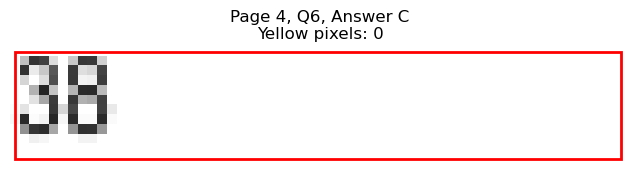

Page 4, Q6 - D: Detected box: x0=327.5, y0=482.5, x1=340.1, y1=493.5
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 65
Page 4, Q6, D: Yellow percentage: 0.0%


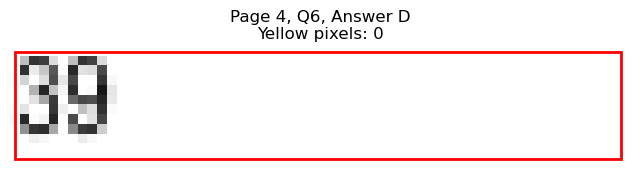


Page 4, Q6 - Selected Answer: A (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=68.3, y0=545.5, x1=254.4, y1=556.5
Page 4, Q7, A: Yellow pixels: 213
Page 4, Q7, A: Total non-white pixels: 1098
Page 4, Q7, A: Yellow percentage: 19.4%


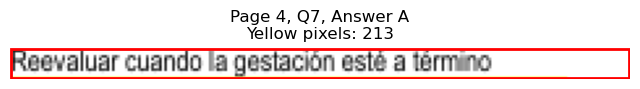

Page 4, Q7 - B: Detected box: x0=68.3, y0=558.2, x1=225.8, y1=569.2
Page 4, Q7, B: Yellow pixels: 1674
Page 4, Q7, B: Total non-white pixels: 2294
Page 4, Q7, B: Yellow percentage: 73.0%


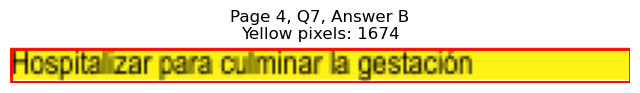

Page 4, Q7 - C: Detected box: x0=327.5, y0=545.5, x1=525.0, y1=556.5
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 998
Page 4, Q7, C: Yellow percentage: 0.0%


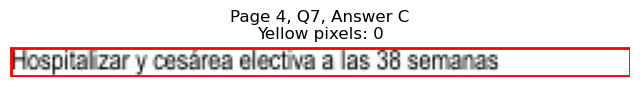

Page 4, Q7 - D: Detected box: x0=327.5, y0=558.2, x1=469.9, y1=569.2
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 748
Page 4, Q7, D: Yellow percentage: 0.0%


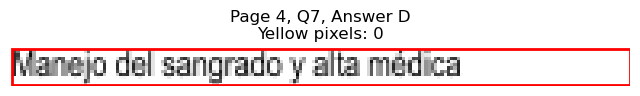


Page 4, Q7 - Selected Answer: B (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=68.3, y0=633.9, x1=127.9, y1=645.0
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 287
Page 4, Q8, A: Yellow percentage: 0.0%


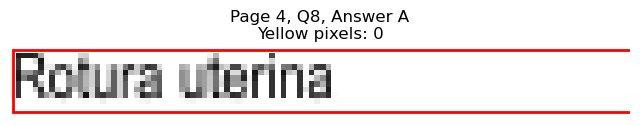

Page 4, Q8 - B: Detected box: x0=68.3, y0=646.5, x1=159.0, y1=657.6
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 447
Page 4, Q8, B: Yellow percentage: 0.0%


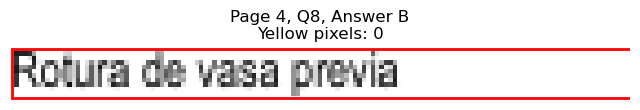

Page 4, Q8 - C: Detected box: x0=327.5, y0=633.9, x1=466.3, y1=645.0
Page 4, Q8, C: Yellow pixels: 1742
Page 4, Q8, C: Total non-white pixels: 2280
Page 4, Q8, C: Yellow percentage: 76.4%


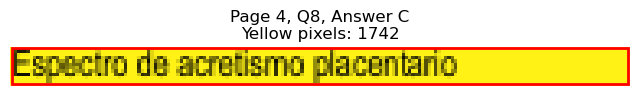

Page 4, Q8 - D: Detected box: x0=327.5, y0=646.5, x1=439.3, y1=657.6
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 583
Page 4, Q8, D: Yellow percentage: 0.0%


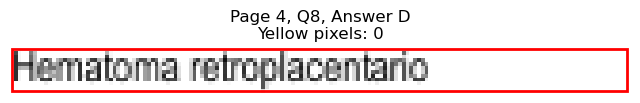


Page 4, Q8 - Selected Answer: C (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=68.3, y0=684.3, x1=179.2, y1=695.4
Page 4, Q9, A: Yellow pixels: 162
Page 4, Q9, A: Total non-white pixels: 710
Page 4, Q9, A: Yellow percentage: 22.8%


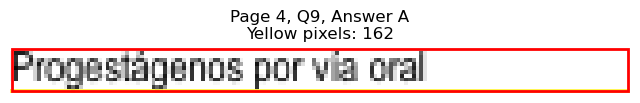

Page 4, Q9 - B: Detected box: x0=68.3, y0=697.0, x1=261.4, y1=708.1
Page 4, Q9, B: Yellow pixels: 1561
Page 4, Q9, B: Total non-white pixels: 2359
Page 4, Q9, B: Yellow percentage: 66.2%


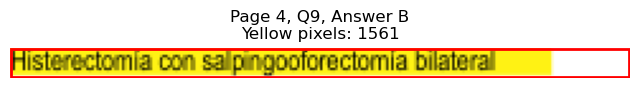

Page 4, Q9 - C: Detected box: x0=327.5, y0=684.3, x1=420.2, y1=695.4
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 503
Page 4, Q9, C: Yellow percentage: 0.0%


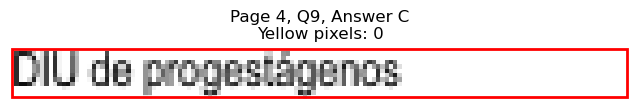

Page 4, Q9 - D: Detected box: x0=327.5, y0=697.0, x1=405.2, y1=708.1
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 417
Page 4, Q9, D: Yellow percentage: 0.0%


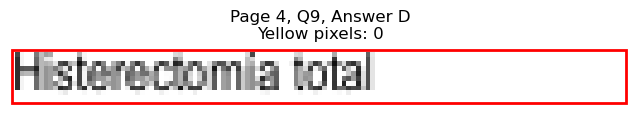


Page 4, Q9 - Selected Answer: B (based on yellow pixel count)





Page 5: Found 9 questions
Page 5, Q1 - A: Detected box: x0=56.6, y0=129.0, x1=65.2, y1=140.0
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 60
Page 5, Q1, A: Yellow percentage: 0.0%


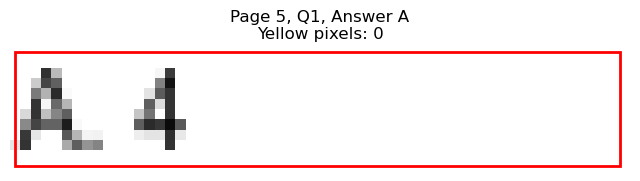

Page 5, Q1 - B: Detected box: x0=56.6, y0=141.7, x1=65.2, y1=152.7
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 76
Page 5, Q1, B: Yellow percentage: 0.0%


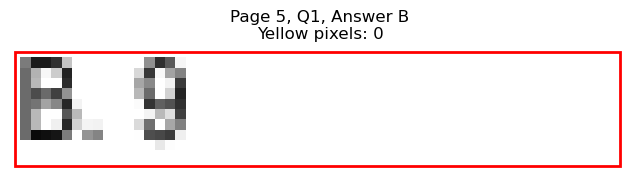

Page 5, Q1 - C: Detected box: x0=315.4, y0=129.0, x1=324.4, y1=140.0
Page 5, Q1, C: Yellow pixels: 674
Page 5, Q1, C: Total non-white pixels: 720
Page 5, Q1, C: Yellow percentage: 93.6%


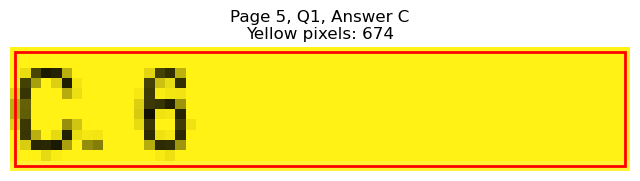

Page 5, Q1 - D: Detected box: x0=327.5, y0=141.7, x1=340.1, y1=152.7
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 39
Page 5, Q1, D: Yellow percentage: 0.0%


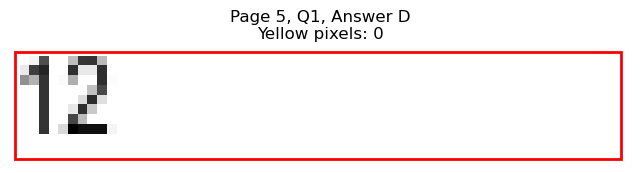


Page 5, Q1 - Selected Answer: C (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=68.3, y0=192.1, x1=89.9, y1=203.1
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 109
Page 5, Q2, A: Yellow percentage: 0.0%


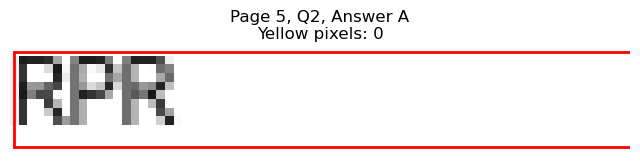

Page 5, Q2 - B: Detected box: x0=68.3, y0=204.7, x1=94.8, y1=215.7
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 121
Page 5, Q2, B: Yellow percentage: 0.0%


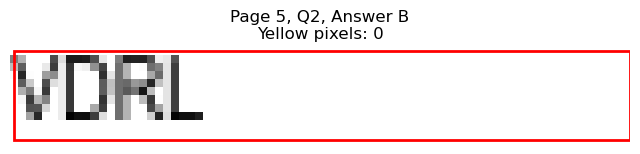

Page 5, Q2 - C: Detected box: x0=327.5, y0=192.1, x1=368.0, y1=203.1
Page 5, Q2, C: Yellow pixels: 864
Page 5, Q2, C: Total non-white pixels: 1012
Page 5, Q2, C: Yellow percentage: 85.4%


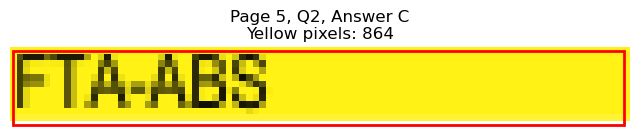

Page 5, Q2 - D: Detected box: x0=327.5, y0=204.7, x1=446.9, y1=215.7
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 643
Page 5, Q2, D: Yellow percentage: 0.0%


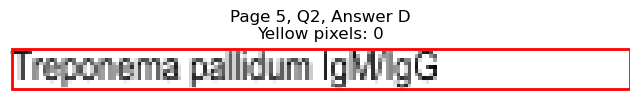


Page 5, Q2 - Selected Answer: C (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=68.3, y0=267.8, x1=303.0, y1=278.8
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 1173
Page 5, Q3, A: Yellow percentage: 0.0%


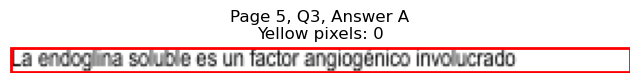

Page 5, Q3 - B: Detected box: x0=68.3, y0=280.5, x1=401.3, y1=291.6
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 1697
Page 5, Q3, B: Yellow percentage: 0.0%


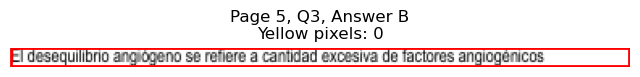

Page 5, Q3 - C: Detected box: x0=68.8, y0=293.1, x1=370.7, y1=304.2
Page 5, Q3, C: Yellow pixels: 353
Page 5, Q3, C: Total non-white pixels: 2216
Page 5, Q3, C: Yellow percentage: 15.9%


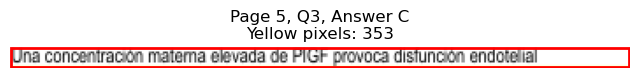

Page 5, Q3 - D: Detected box: x0=68.8, y0=305.7, x1=241.9, y1=316.8
Page 5, Q3, D: Yellow pixels: 2057
Page 5, Q3, D: Total non-white pixels: 2688
Page 5, Q3, D: Yellow percentage: 76.5%


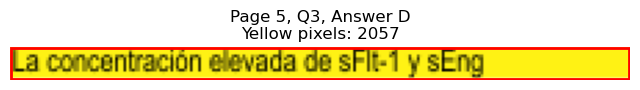


Page 5, Q3 - Selected Answer: D (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=68.3, y0=356.2, x1=247.8, y1=367.3
Page 5, Q4, A: Yellow pixels: 213
Page 5, Q4, A: Total non-white pixels: 1123
Page 5, Q4, A: Yellow percentage: 19.0%


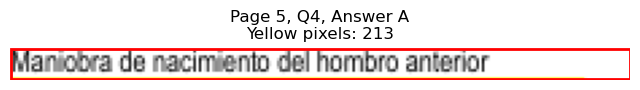

Page 5, Q4 - B: Detected box: x0=68.3, y0=368.8, x1=147.0, y1=379.9
Page 5, Q4, B: Yellow pixels: 1244
Page 5, Q4, B: Total non-white pixels: 1548
Page 5, Q4, B: Yellow percentage: 80.4%


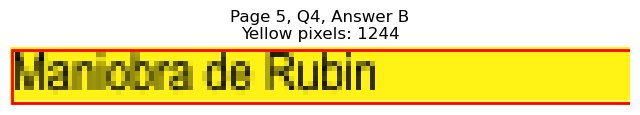

Page 5, Q4 - C: Detected box: x0=327.5, y0=356.2, x1=405.7, y1=367.3
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 410
Page 5, Q4, C: Yellow percentage: 0.0%


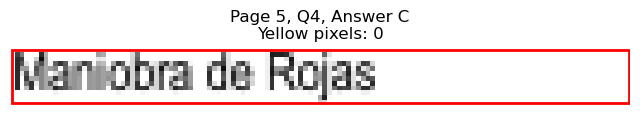

Page 5, Q4 - D: Detected box: x0=327.5, y0=368.8, x1=378.1, y1=379.9
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 258
Page 5, Q4, D: Yellow percentage: 0.0%


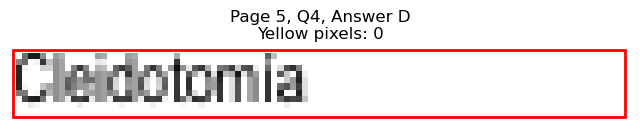


Page 5, Q4 - Selected Answer: B (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=68.3, y0=406.6, x1=306.0, y1=417.7
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 1159
Page 5, Q5, A: Yellow percentage: 0.0%


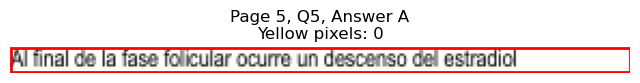

Page 5, Q5 - B: Detected box: x0=68.3, y0=419.4, x1=215.8, y1=430.4
Page 5, Q5, B: Yellow pixels: 198
Page 5, Q5, B: Total non-white pixels: 932
Page 5, Q5, B: Yellow percentage: 21.2%


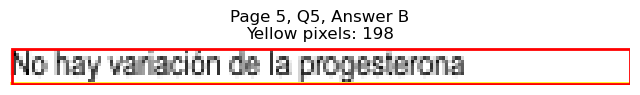

Page 5, Q5 - C: Detected box: x0=68.8, y0=432.0, x1=264.4, y1=443.0
Page 5, Q5, C: Yellow pixels: 2236
Page 5, Q5, C: Total non-white pixels: 2964
Page 5, Q5, C: Yellow percentage: 75.4%


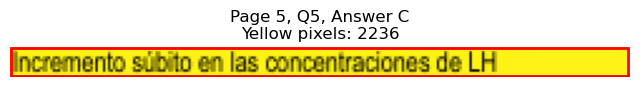

Page 5, Q5 - D: Detected box: x0=68.8, y0=444.6, x1=234.2, y1=455.6
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 827
Page 5, Q5, D: Yellow percentage: 0.0%


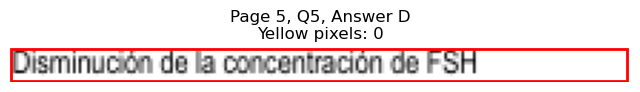


Page 5, Q5 - Selected Answer: C (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=68.3, y0=520.3, x1=118.4, y1=531.3
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 242
Page 5, Q6, A: Yellow percentage: 0.0%


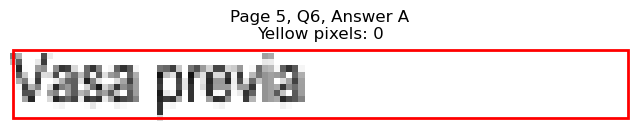

Page 5, Q6 - B: Detected box: x0=68.3, y0=532.9, x1=231.7, y1=543.9
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 840
Page 5, Q6, B: Yellow percentage: 0.0%


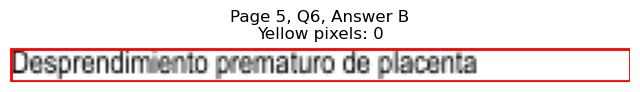

Page 5, Q6 - C: Detected box: x0=327.5, y0=520.3, x1=416.8, y1=531.3
Page 5, Q6, C: Yellow pixels: 140
Page 5, Q6, C: Total non-white pixels: 598
Page 5, Q6, C: Yellow percentage: 23.4%


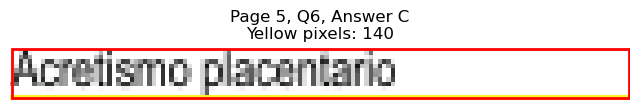

Page 5, Q6 - D: Detected box: x0=327.5, y0=532.9, x1=387.1, y1=543.9
Page 5, Q6, D: Yellow pixels: 1117
Page 5, Q6, D: Total non-white pixels: 1332
Page 5, Q6, D: Yellow percentage: 83.9%


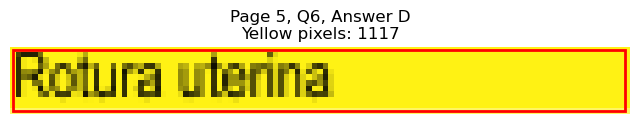


Page 5, Q6 - Selected Answer: D (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=68.3, y0=583.4, x1=148.6, y1=594.4
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 403
Page 5, Q7, A: Yellow percentage: 0.0%


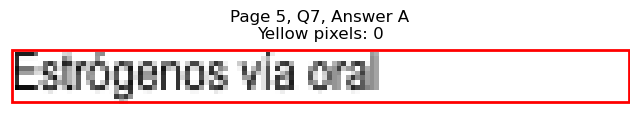

Page 5, Q7 - B: Detected box: x0=68.3, y0=596.0, x1=169.1, y1=607.0
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 524
Page 5, Q7, B: Yellow percentage: 0.0%


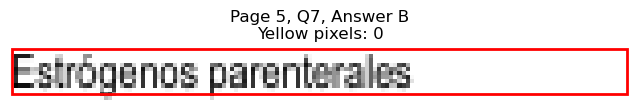

Page 5, Q7 - C: Detected box: x0=327.5, y0=583.4, x1=442.8, y1=594.4
Page 5, Q7, C: Yellow pixels: 1340
Page 5, Q7, C: Total non-white pixels: 1992
Page 5, Q7, C: Yellow percentage: 67.3%


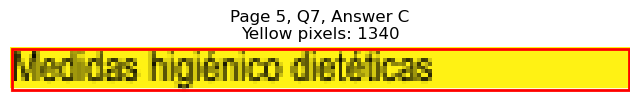

Page 5, Q7 - D: Detected box: x0=327.5, y0=596.0, x1=446.4, y1=607.0
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 617
Page 5, Q7, D: Yellow percentage: 0.0%


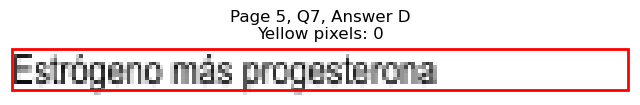


Page 5, Q7 - Selected Answer: C (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=68.3, y0=646.5, x1=154.6, y1=657.6
Page 5, Q8, A: Yellow pixels: 137
Page 5, Q8, A: Total non-white pixels: 597
Page 5, Q8, A: Yellow percentage: 22.9%


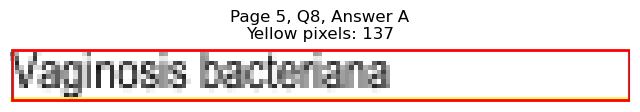

Page 5, Q8 - B: Detected box: x0=68.3, y0=659.1, x1=148.6, y1=670.2
Page 5, Q8, B: Yellow pixels: 1094
Page 5, Q8, B: Total non-white pixels: 1444
Page 5, Q8, B: Yellow percentage: 75.8%


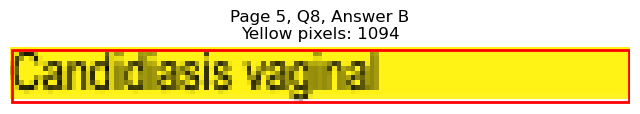

Page 5, Q8 - C: Detected box: x0=327.5, y0=646.5, x1=416.8, y1=657.6
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 470
Page 5, Q8, C: Yellow percentage: 0.0%


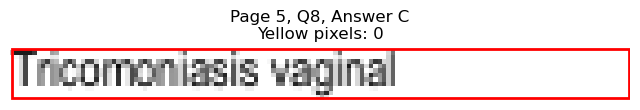

Page 5, Q8 - D: Detected box: x0=327.5, y0=659.1, x1=417.2, y1=670.2
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 470
Page 5, Q8, D: Yellow percentage: 0.0%


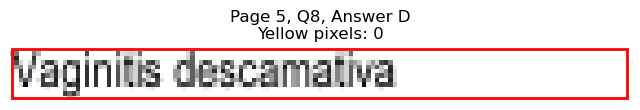


Page 5, Q8 - Selected Answer: B (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=68.3, y0=722.2, x1=301.0, y1=733.3
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 1120
Page 5, Q9, A: Yellow percentage: 0.0%


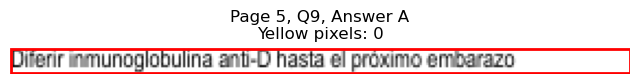

Page 5, Q9 - B: Detected box: x0=68.3, y0=734.8, x1=216.7, y1=745.9
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 774
Page 5, Q9, B: Yellow percentage: 0.0%


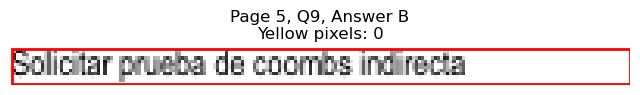

Page 5, Q9 - C: Detected box: x0=68.8, y0=747.4, x1=219.1, y1=758.5
Page 5, Q9, C: Yellow pixels: 202
Page 5, Q9, C: Total non-white pixels: 942
Page 5, Q9, C: Yellow percentage: 21.4%


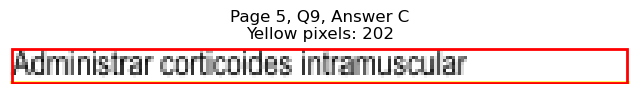

Page 5, Q9 - D: Detected box: x0=68.8, y0=760.2, x1=263.9, y1=771.2
Page 5, Q9, D: Yellow pixels: 1909
Page 5, Q9, D: Total non-white pixels: 2709
Page 5, Q9, D: Yellow percentage: 70.5%


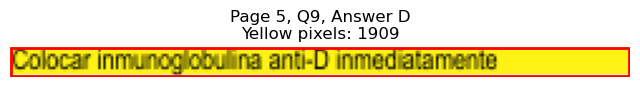


Page 5, Q9 - Selected Answer: D (based on yellow pixel count)





Page 6: Found 10 questions
Page 6, Q1 - A: Detected box: x0=68.3, y0=116.4, x1=195.7, y1=127.4
Page 6, Q1, A: Yellow pixels: 1461
Page 6, Q1, A: Total non-white pixels: 2136
Page 6, Q1, A: Yellow percentage: 68.4%


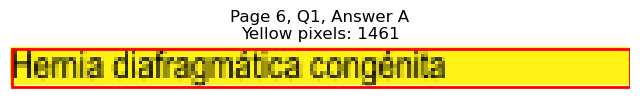

Page 6, Q1 - B: Detected box: x0=68.3, y0=129.0, x1=151.6, y1=140.0
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 411
Page 6, Q1, B: Yellow percentage: 0.0%


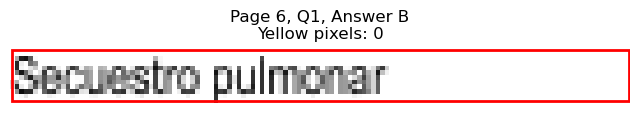

Page 6, Q1 - C: Detected box: x0=327.5, y0=116.4, x1=474.8, y1=127.4
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 778
Page 6, Q1, C: Yellow percentage: 0.0%


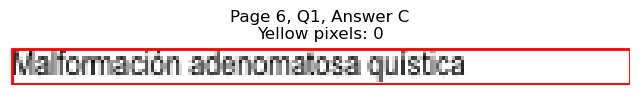

Page 6, Q1 - D: Detected box: x0=327.5, y0=129.0, x1=362.0, y1=140.0
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 170
Page 6, Q1, D: Yellow percentage: 0.0%


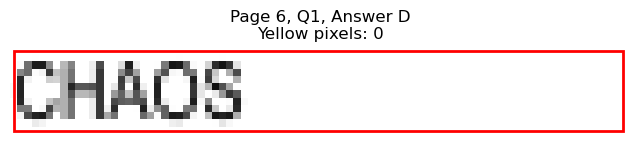


Page 6, Q1 - Selected Answer: A (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=68.3, y0=179.5, x1=142.6, y1=190.5
Page 6, Q2, A: Yellow pixels: 1094
Page 6, Q2, A: Total non-white pixels: 1500
Page 6, Q2, A: Yellow percentage: 72.9%


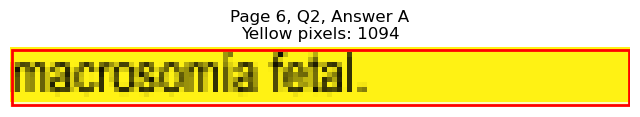

Page 6, Q2 - B: Detected box: x0=68.3, y0=192.1, x1=141.0, y1=203.1
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 354
Page 6, Q2, B: Yellow percentage: 0.0%


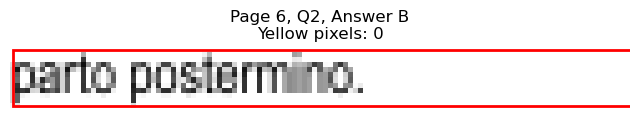

Page 6, Q2 - C: Detected box: x0=327.5, y0=179.5, x1=432.8, y1=190.5
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 541
Page 6, Q2, C: Yellow percentage: 0.0%


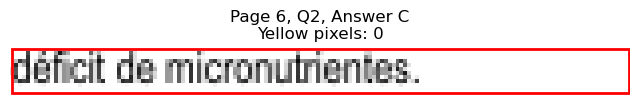

Page 6, Q2 - D: Detected box: x0=327.5, y0=192.1, x1=354.6, y1=203.1
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 127
Page 6, Q2, D: Yellow percentage: 0.0%


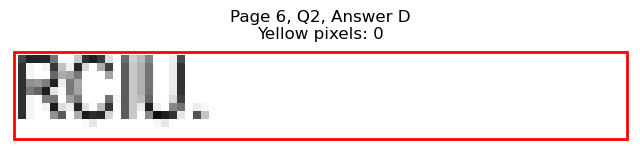


Page 6, Q2 - Selected Answer: A (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=68.3, y0=242.6, x1=302.4, y1=253.6
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 1163
Page 6, Q3, A: Yellow percentage: 0.0%


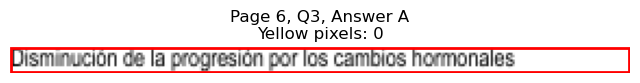

Page 6, Q3 - B: Detected box: x0=68.3, y0=255.2, x1=238.8, y1=266.2
Page 6, Q3, B: Yellow pixels: 221
Page 6, Q3, B: Total non-white pixels: 1083
Page 6, Q3, B: Yellow percentage: 20.4%


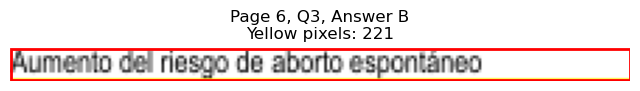

Page 6, Q3 - C: Detected box: x0=68.8, y0=267.8, x1=228.2, y1=278.8
Page 6, Q3, C: Yellow pixels: 1922
Page 6, Q3, C: Total non-white pixels: 2532
Page 6, Q3, C: Yellow percentage: 75.9%


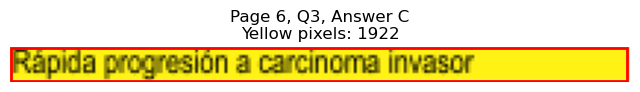

Page 6, Q3 - D: Detected box: x0=68.8, y0=280.5, x1=316.0, y1=291.6
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 1198
Page 6, Q3, D: Yellow percentage: 0.0%


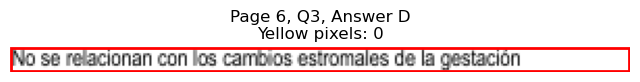


Page 6, Q3 - Selected Answer: C (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=68.3, y0=318.3, x1=216.2, y1=329.4
Page 6, Q4, A: Yellow pixels: 199
Page 6, Q4, A: Total non-white pixels: 928
Page 6, Q4, A: Yellow percentage: 21.4%


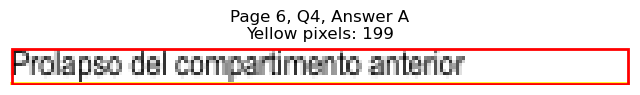

Page 6, Q4 - B: Detected box: x0=68.3, y0=330.9, x1=179.2, y1=342.0
Page 6, Q4, B: Yellow pixels: 1557
Page 6, Q4, B: Total non-white pixels: 1944
Page 6, Q4, B: Yellow percentage: 80.1%


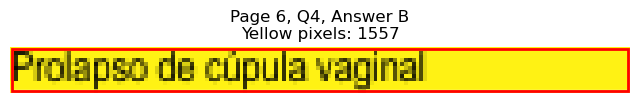

Page 6, Q4 - C: Detected box: x0=327.5, y0=318.3, x1=480.0, y1=329.4
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 742
Page 6, Q4, C: Yellow percentage: 0.0%


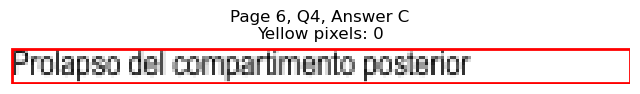

Page 6, Q4 - D: Detected box: x0=327.5, y0=330.9, x1=465.5, y1=342.0
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 700
Page 6, Q4, D: Yellow percentage: 0.0%


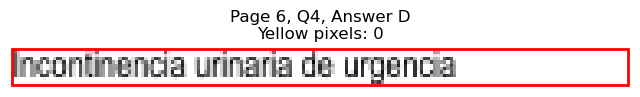


Page 6, Q4 - Selected Answer: B (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=68.3, y0=368.8, x1=196.2, y1=379.9
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 607
Page 6, Q5, A: Yellow percentage: 0.0%


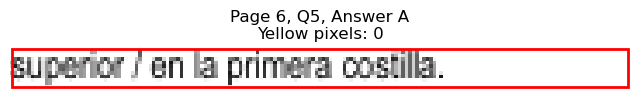

Page 6, Q5 - B: Detected box: x0=68.3, y0=381.4, x1=185.2, y1=392.5
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 551
Page 6, Q5, B: Yellow percentage: 0.0%


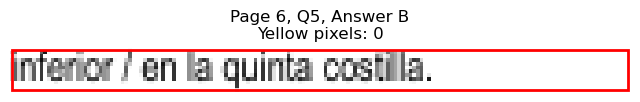

Page 6, Q5 - C: Detected box: x0=68.8, y0=394.0, x1=198.6, y1=405.1
Page 6, Q5, C: Yellow pixels: 181
Page 6, Q5, C: Total non-white pixels: 963
Page 6, Q5, C: Yellow percentage: 18.8%


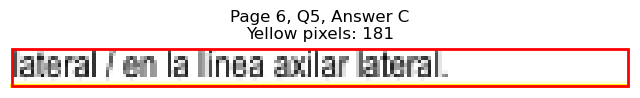

Page 6, Q5 - D: Detected box: x0=68.8, y0=406.6, x1=287.9, y1=417.7
Page 6, Q5, D: Yellow pixels: 2449
Page 6, Q5, D: Total non-white pixels: 3240
Page 6, Q5, D: Yellow percentage: 75.6%


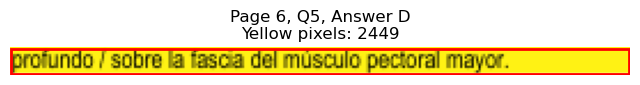


Page 6, Q5 - Selected Answer: D (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=68.3, y0=482.5, x1=84.4, y1=493.5
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 64
Page 6, Q6, A: Yellow percentage: 0.0%


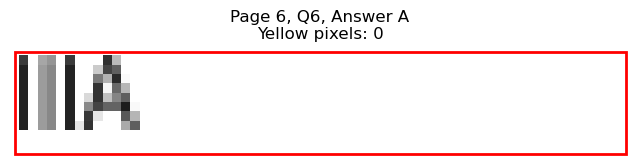

Page 6, Q6 - B: Detected box: x0=68.3, y0=495.1, x1=84.4, y1=506.1
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 70
Page 6, Q6, B: Yellow percentage: 0.0%


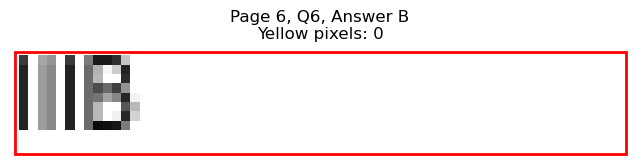

Page 6, Q6 - C: Detected box: x0=327.5, y0=482.5, x1=341.0, y1=493.5
Page 6, Q6, C: Yellow pixels: 65
Page 6, Q6, C: Total non-white pixels: 128
Page 6, Q6, C: Yellow percentage: 50.8%


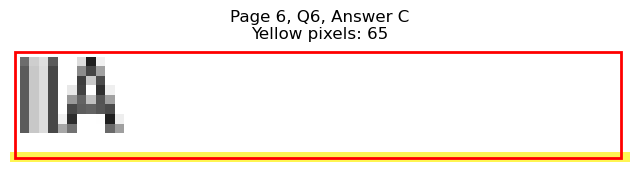

Page 6, Q6 - D: Detected box: x0=327.5, y0=495.1, x1=341.0, y1=506.1
Page 6, Q6, D: Yellow pixels: 662
Page 6, Q6, D: Total non-white pixels: 715
Page 6, Q6, D: Yellow percentage: 92.6%


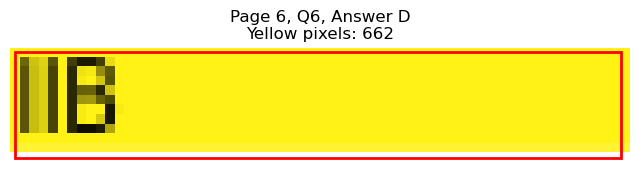


Page 6, Q6 - Selected Answer: D (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=68.3, y0=532.9, x1=100.6, y1=543.9
Page 6, Q7, A: Yellow pixels: 891
Page 6, Q7, A: Total non-white pixels: 996
Page 6, Q7, A: Yellow percentage: 89.5%


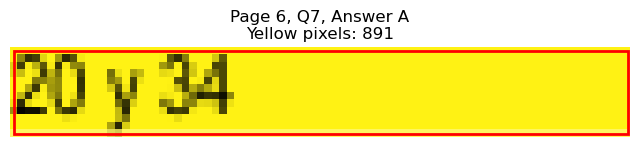

Page 6, Q7 - B: Detected box: x0=68.3, y0=545.5, x1=100.4, y1=556.5
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 147
Page 6, Q7, B: Yellow percentage: 0.0%


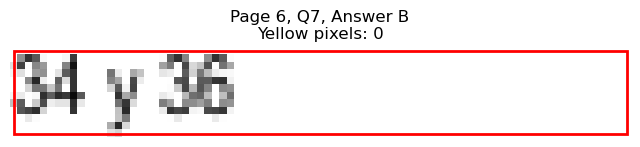

Page 6, Q7 - C: Detected box: x0=327.5, y0=532.9, x1=359.6, y1=543.9
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 138
Page 6, Q7, C: Yellow percentage: 0.0%


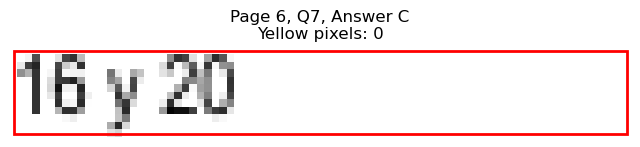

Page 6, Q7 - D: Detected box: x0=327.5, y0=545.5, x1=359.6, y1=556.5
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 150
Page 6, Q7, D: Yellow percentage: 0.0%


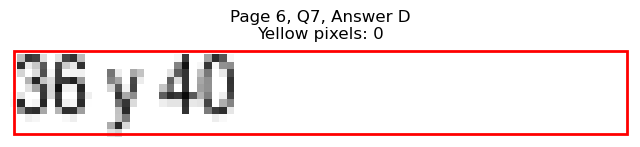


Page 6, Q7 - Selected Answer: A (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=68.3, y0=621.3, x1=151.6, y1=632.4
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 440
Page 6, Q8, A: Yellow percentage: 0.0%


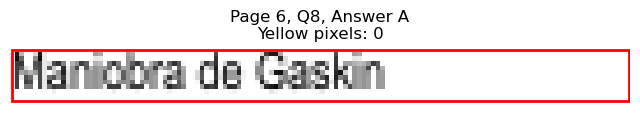

Page 6, Q8 - B: Detected box: x0=68.3, y0=633.9, x1=122.4, y1=645.0
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 294
Page 6, Q8, B: Yellow percentage: 0.0%


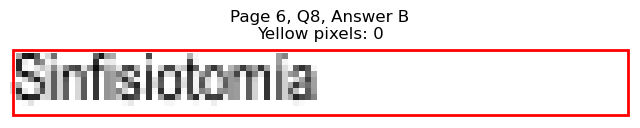

Page 6, Q8 - C: Detected box: x0=327.5, y0=621.3, x1=423.7, y1=632.4
Page 6, Q8, C: Yellow pixels: 1244
Page 6, Q8, C: Total non-white pixels: 1764
Page 6, Q8, C: Yellow percentage: 70.5%


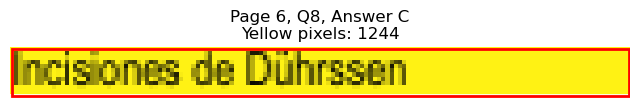

Page 6, Q8 - D: Detected box: x0=327.5, y0=633.9, x1=408.7, y1=645.0
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 437
Page 6, Q8, D: Yellow percentage: 0.0%


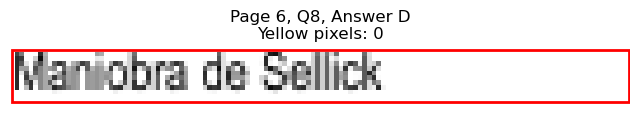


Page 6, Q8 - Selected Answer: C (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=68.3, y0=697.0, x1=139.4, y1=708.1
Page 6, Q9, A: Yellow pixels: 122
Page 6, Q9, A: Total non-white pixels: 590
Page 6, Q9, A: Yellow percentage: 20.7%


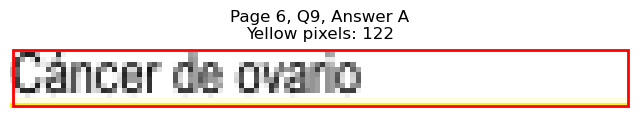

Page 6, Q9 - B: Detected box: x0=68.3, y0=709.6, x1=132.0, y1=720.7
Page 6, Q9, B: Yellow pixels: 1133
Page 6, Q9, B: Total non-white pixels: 1368
Page 6, Q9, B: Yellow percentage: 82.8%


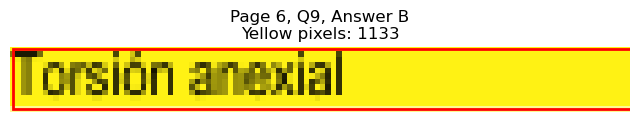

Page 6, Q9 - C: Detected box: x0=327.5, y0=697.0, x1=412.2, y1=708.1
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 448
Page 6, Q9, C: Yellow percentage: 0.0%


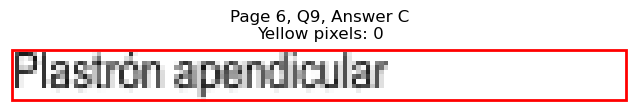

Page 6, Q9 - D: Detected box: x0=327.5, y0=709.6, x1=416.3, y1=720.7
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 434
Page 6, Q9, D: Yellow percentage: 0.0%


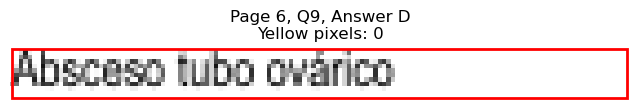


Page 6, Q9 - Selected Answer: B (based on yellow pixel count)




Page 6, Q10 - A: Detected box: x0=68.3, y0=747.4, x1=137.0, y1=758.5
Page 6, Q10, A: Yellow pixels: 0
Page 6, Q10, A: Total non-white pixels: 365
Page 6, Q10, A: Yellow percentage: 0.0%


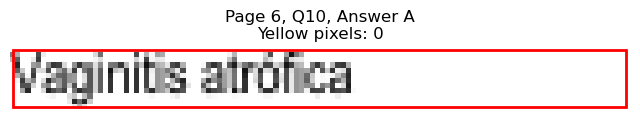

Page 6, Q10 - B: Detected box: x0=68.3, y0=760.2, x1=188.2, y1=771.2
Page 6, Q10, B: Yellow pixels: 0
Page 6, Q10, B: Total non-white pixels: 641
Page 6, Q10, B: Yellow percentage: 0.0%


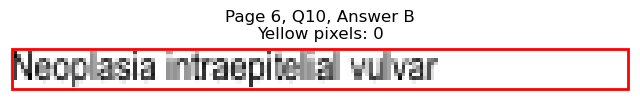

Page 6, Q10 - C: Detected box: x0=327.5, y0=747.4, x1=422.3, y1=758.5
Page 6, Q10, C: Yellow pixels: 1240
Page 6, Q10, C: Total non-white pixels: 1752
Page 6, Q10, C: Yellow percentage: 70.8%


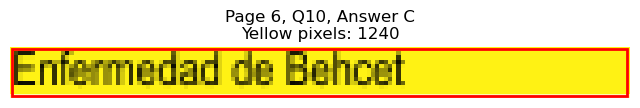

Page 6, Q10 - D: Detected box: x0=327.5, y0=760.2, x1=426.2, y1=771.2
Page 6, Q10, D: Yellow pixels: 0
Page 6, Q10, D: Total non-white pixels: 479
Page 6, Q10, D: Yellow percentage: 0.0%


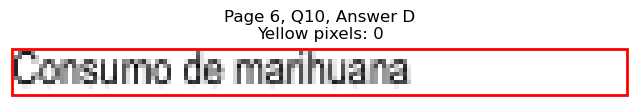


Page 6, Q10 - Selected Answer: C (based on yellow pixel count)





Page 7: Found 12 questions
Page 7, Q1 - A: Detected box: x0=68.3, y0=116.4, x1=169.6, y1=127.4
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 560
Page 7, Q1, A: Yellow percentage: 0.0%


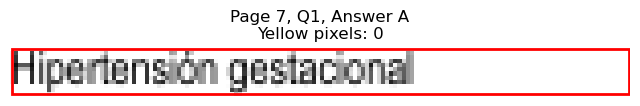

Page 7, Q1 - B: Detected box: x0=68.3, y0=129.0, x1=153.0, y1=140.0
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 447
Page 7, Q1, B: Yellow percentage: 0.0%


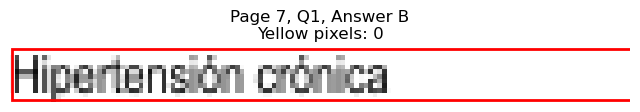

Page 7, Q1 - C: Detected box: x0=327.5, y0=116.4, x1=400.2, y1=127.4
Page 7, Q1, C: Yellow pixels: 124
Page 7, Q1, C: Total non-white pixels: 477
Page 7, Q1, C: Yellow percentage: 26.0%


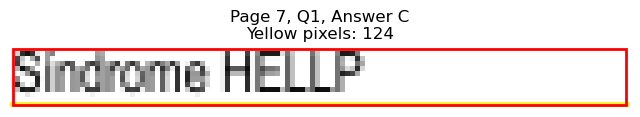

Page 7, Q1 - D: Detected box: x0=327.5, y0=129.0, x1=484.4, y1=140.0
Page 7, Q1, D: Yellow pixels: 1888
Page 7, Q1, D: Total non-white pixels: 2496
Page 7, Q1, D: Yellow percentage: 75.6%


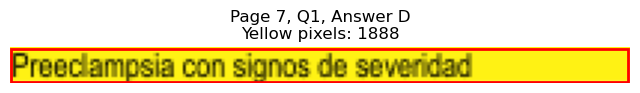


Page 7, Q1 - Selected Answer: D (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=68.3, y0=166.9, x1=163.6, y1=177.9
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 488
Page 7, Q2, A: Yellow percentage: 0.0%


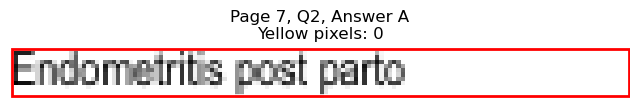

Page 7, Q2 - B: Detected box: x0=68.3, y0=179.5, x1=231.7, y1=190.5
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 840
Page 7, Q2, B: Yellow percentage: 0.0%


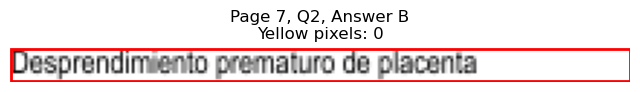

Page 7, Q2 - C: Detected box: x0=327.5, y0=166.9, x1=467.5, y1=177.9
Page 7, Q2, C: Yellow pixels: 1
Page 7, Q2, C: Total non-white pixels: 893
Page 7, Q2, C: Yellow percentage: 0.1%


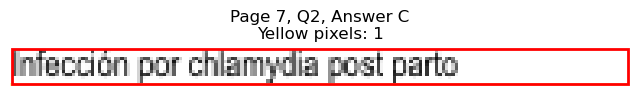

Page 7, Q2 - D: Detected box: x0=327.5, y0=179.5, x1=395.2, y1=190.5
Page 7, Q2, D: Yellow pixels: 1075
Page 7, Q2, D: Total non-white pixels: 1428
Page 7, Q2, D: Yellow percentage: 75.3%


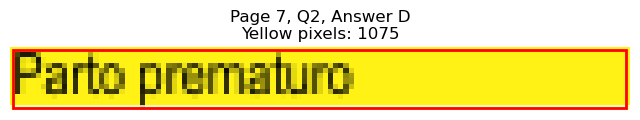


Page 7, Q2 - Selected Answer: D (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=68.3, y0=217.4, x1=157.6, y1=228.4
Page 7, Q3, A: Yellow pixels: 1209
Page 7, Q3, A: Total non-white pixels: 1680
Page 7, Q3, A: Yellow percentage: 72.0%


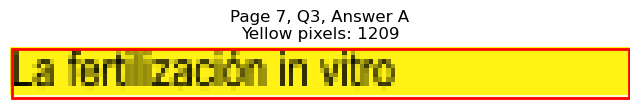

Page 7, Q3 - B: Detected box: x0=68.3, y0=230.0, x1=167.6, y1=241.0
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 490
Page 7, Q3, B: Yellow percentage: 0.0%


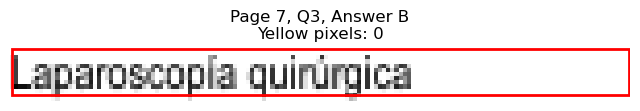

Page 7, Q3 - C: Detected box: x0=327.5, y0=217.4, x1=409.7, y1=228.4
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 414
Page 7, Q3, C: Yellow percentage: 0.0%


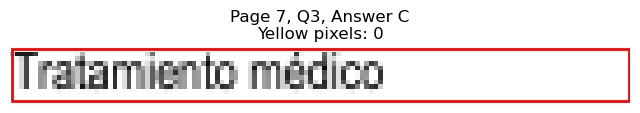

Page 7, Q3 - D: Detected box: x0=327.5, y0=230.0, x1=430.8, y1=241.0
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 541
Page 7, Q3, D: Yellow percentage: 0.0%


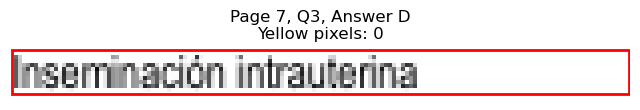


Page 7, Q3 - Selected Answer: A (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=68.3, y0=267.8, x1=97.3, y1=278.8
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 144
Page 7, Q4, A: Yellow percentage: 0.0%


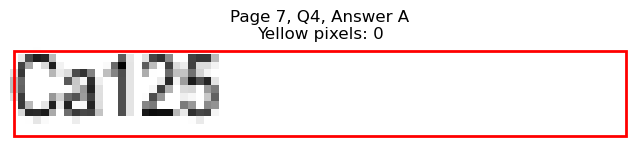

Page 7, Q4 - B: Detected box: x0=68.3, y0=280.5, x1=89.4, y1=291.6
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 98
Page 7, Q4, B: Yellow percentage: 0.0%


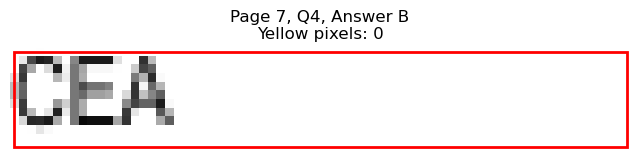

Page 7, Q4 - C: Detected box: x0=327.5, y0=267.8, x1=348.0, y1=278.8
Page 7, Q4, C: Yellow pixels: 783
Page 7, Q4, C: Total non-white pixels: 852
Page 7, Q4, C: Yellow percentage: 91.9%


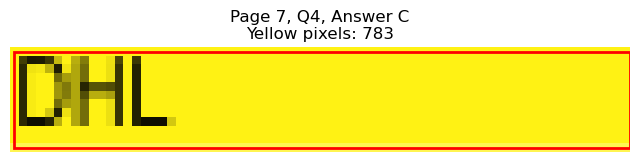

Page 7, Q4 - D: Detected box: x0=327.5, y0=280.5, x1=362.0, y1=291.6
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 143
Page 7, Q4, D: Yellow percentage: 0.0%


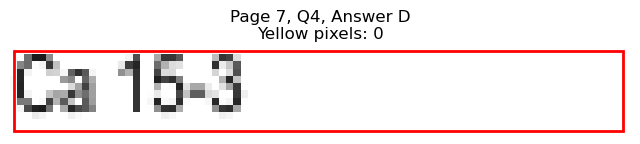


Page 7, Q4 - Selected Answer: C (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=68.3, y0=318.3, x1=232.8, y1=329.4
Page 7, Q5, A: Yellow pixels: 1742
Page 7, Q5, A: Total non-white pixels: 2568
Page 7, Q5, A: Yellow percentage: 67.8%


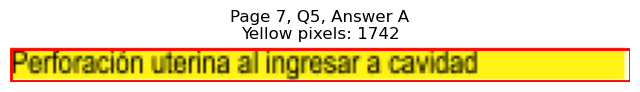

Page 7, Q5 - B: Detected box: x0=68.3, y0=330.9, x1=143.0, y1=342.0
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 375
Page 7, Q5, B: Yellow percentage: 0.0%


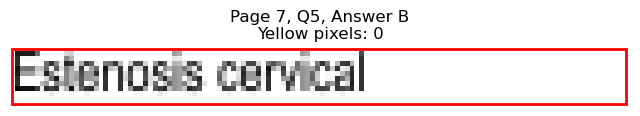

Page 7, Q5 - C: Detected box: x0=327.5, y0=318.3, x1=465.8, y1=329.4
Page 7, Q5, C: Yellow pixels: 0
Page 7, Q5, C: Total non-white pixels: 718
Page 7, Q5, C: Yellow percentage: 0.0%


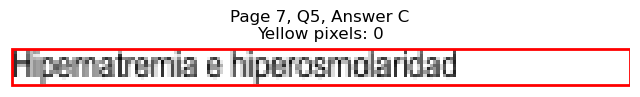

Page 7, Q5 - D: Detected box: x0=327.5, y0=330.9, x1=456.8, y1=342.0
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 691
Page 7, Q5, D: Yellow percentage: 0.0%


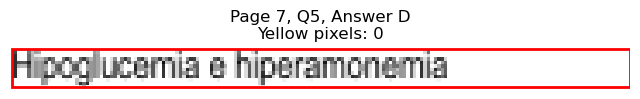


Page 7, Q5 - Selected Answer: A (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=68.3, y0=368.8, x1=139.6, y1=379.9
Page 7, Q6, A: Yellow pixels: 2
Page 7, Q6, A: Total non-white pixels: 509
Page 7, Q6, A: Yellow percentage: 0.4%


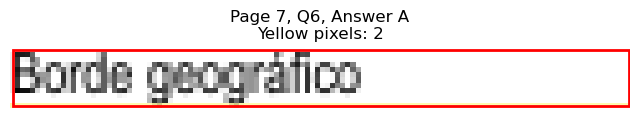

Page 7, Q6 - B: Detected box: x0=68.3, y0=381.4, x1=121.9, y1=392.5
Page 7, Q6, B: Yellow pixels: 929
Page 7, Q6, B: Total non-white pixels: 1248
Page 7, Q6, B: Yellow percentage: 74.4%


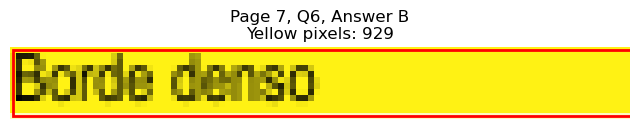

Page 7, Q6 - C: Detected box: x0=327.5, y0=368.8, x1=409.7, y1=379.9
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 408
Page 7, Q6, C: Yellow percentage: 0.0%


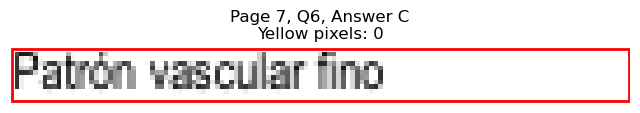

Page 7, Q6 - D: Detected box: x0=327.5, y0=381.4, x1=426.7, y1=392.5
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 524
Page 7, Q6, D: Yellow percentage: 0.0%


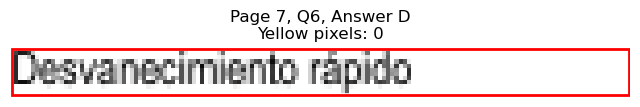


Page 7, Q6 - Selected Answer: B (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=68.3, y0=432.0, x1=151.6, y1=443.0
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 399
Page 7, Q7, A: Yellow percentage: 0.0%


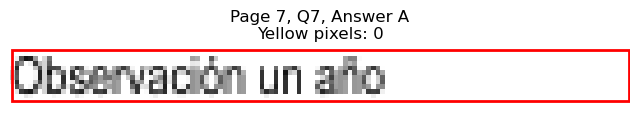

Page 7, Q7 - B: Detected box: x0=68.3, y0=444.6, x1=169.6, y1=455.6
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 466
Page 7, Q7, B: Yellow percentage: 0.0%


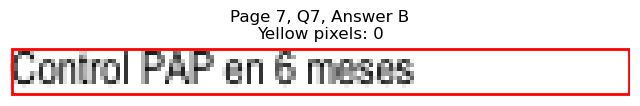

Page 7, Q7 - C: Detected box: x0=327.5, y0=432.0, x1=374.6, y1=443.0
Page 7, Q7, C: Yellow pixels: 993
Page 7, Q7, C: Total non-white pixels: 1176
Page 7, Q7, C: Yellow percentage: 84.4%


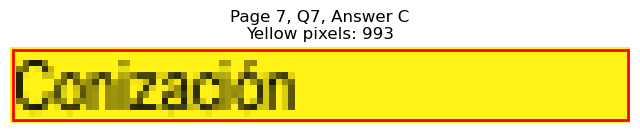

Page 7, Q7 - D: Detected box: x0=327.5, y0=444.6, x1=374.2, y1=455.6
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 251
Page 7, Q7, D: Yellow percentage: 0.0%


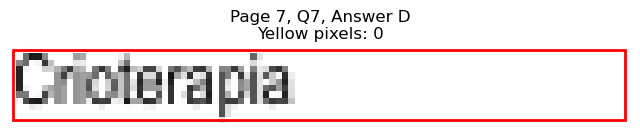


Page 7, Q7 - Selected Answer: C (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=68.3, y0=495.1, x1=247.3, y1=506.1
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 890
Page 7, Q8, A: Yellow percentage: 0.0%


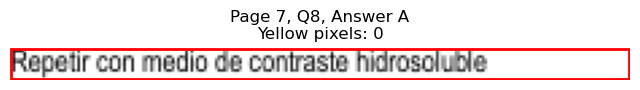

Page 7, Q8 - B: Detected box: x0=68.3, y0=507.7, x1=208.2, y1=518.7
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 721
Page 7, Q8, B: Yellow percentage: 0.0%


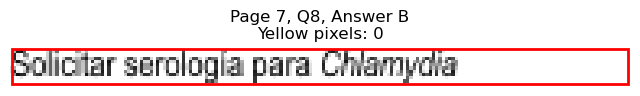

Page 7, Q8 - C: Detected box: x0=327.5, y0=495.1, x1=407.3, y1=506.1
Page 7, Q8, C: Yellow pixels: 131
Page 7, Q8, C: Total non-white pixels: 658
Page 7, Q8, C: Yellow percentage: 19.9%


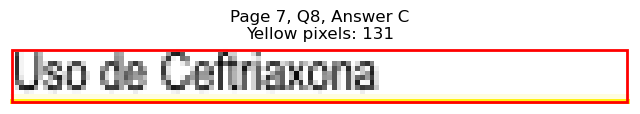

Page 7, Q8 - D: Detected box: x0=327.5, y0=507.7, x1=439.3, y1=518.7
Page 7, Q8, D: Yellow pixels: 1533
Page 7, Q8, D: Total non-white pixels: 1956
Page 7, Q8, D: Yellow percentage: 78.4%


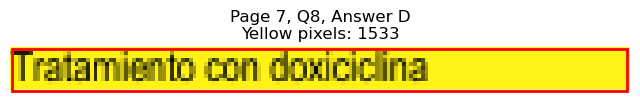


Page 7, Q8 - Selected Answer: D (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=68.3, y0=558.2, x1=146.5, y1=569.2
Page 7, Q9, A: Yellow pixels: 1089
Page 7, Q9, A: Total non-white pixels: 1419
Page 7, Q9, A: Yellow percentage: 76.7%


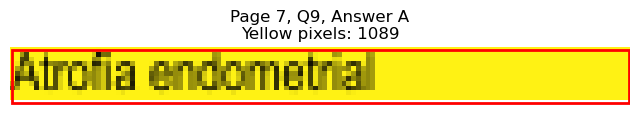

Page 7, Q9 - B: Detected box: x0=68.3, y0=570.8, x1=129.0, y1=581.8
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 299
Page 7, Q9, B: Yellow percentage: 0.0%


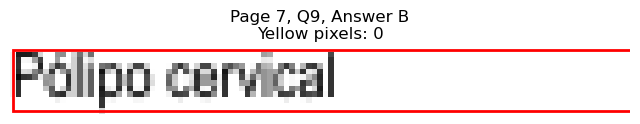

Page 7, Q9 - C: Detected box: x0=327.5, y0=558.2, x1=424.8, y1=569.2
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 540
Page 7, Q9, C: Yellow percentage: 0.0%


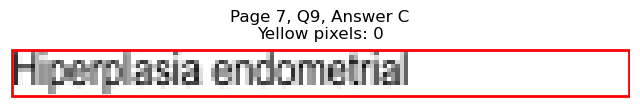

Page 7, Q9 - D: Detected box: x0=327.5, y0=570.8, x1=408.7, y1=581.8
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 425
Page 7, Q9, D: Yellow percentage: 0.0%


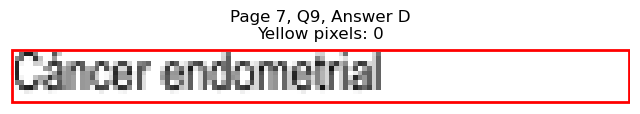


Page 7, Q9 - Selected Answer: A (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=68.3, y0=608.6, x1=106.4, y1=619.6
Page 7, Q10, A: Yellow pixels: 0
Page 7, Q10, A: Total non-white pixels: 199
Page 7, Q10, A: Yellow percentage: 0.0%


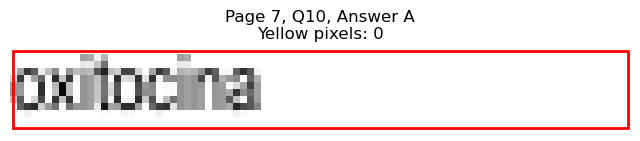

Page 7, Q10 - B: Detected box: x0=68.3, y0=621.3, x1=116.9, y1=632.4
Page 7, Q10, B: Yellow pixels: 0
Page 7, Q10, B: Total non-white pixels: 252
Page 7, Q10, B: Yellow percentage: 0.0%


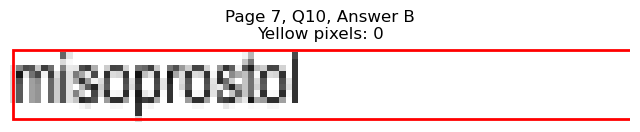

Page 7, Q10 - C: Detected box: x0=327.5, y0=608.6, x1=397.2, y1=619.6
Page 7, Q10, C: Yellow pixels: 1178
Page 7, Q10, C: Total non-white pixels: 1452
Page 7, Q10, C: Yellow percentage: 81.1%


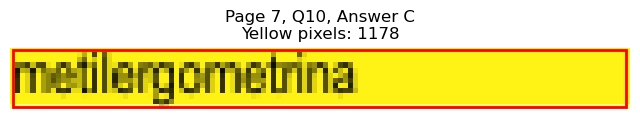

Page 7, Q10 - D: Detected box: x0=327.5, y0=621.3, x1=394.8, y1=632.4
Page 7, Q10, D: Yellow pixels: 0
Page 7, Q10, D: Total non-white pixels: 393
Page 7, Q10, D: Yellow percentage: 0.0%


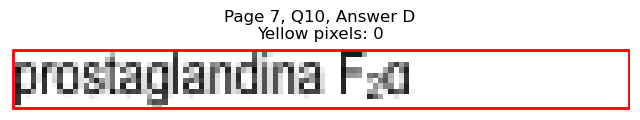


Page 7, Q10 - Selected Answer: C (based on yellow pixel count)




Page 7, Q11 - A: Detected box: x0=68.3, y0=659.1, x1=154.6, y1=670.2
Page 7, Q11, A: Yellow pixels: 0
Page 7, Q11, A: Total non-white pixels: 434
Page 7, Q11, A: Yellow percentage: 0.0%


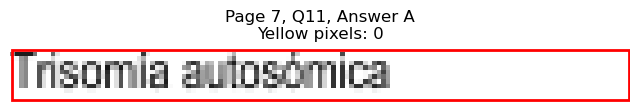

Page 7, Q11 - B: Detected box: x0=68.3, y0=671.7, x1=107.9, y1=682.8
Page 7, Q11, B: Yellow pixels: 0
Page 7, Q11, B: Total non-white pixels: 217
Page 7, Q11, B: Yellow percentage: 0.0%


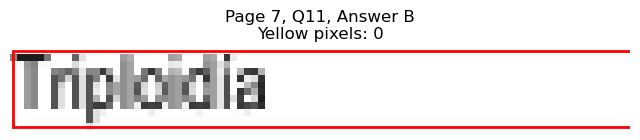

Page 7, Q11 - C: Detected box: x0=327.5, y0=659.1, x1=385.7, y1=670.2
Page 7, Q11, C: Yellow pixels: 981
Page 7, Q11, C: Total non-white pixels: 1199
Page 7, Q11, C: Yellow percentage: 81.8%


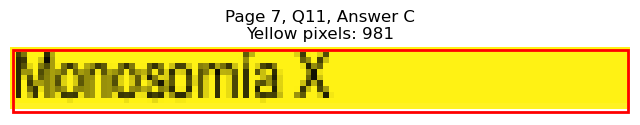

Page 7, Q11 - D: Detected box: x0=327.5, y0=671.7, x1=377.6, y1=682.8
Page 7, Q11, D: Yellow pixels: 0
Page 7, Q11, D: Total non-white pixels: 256
Page 7, Q11, D: Yellow percentage: 0.0%


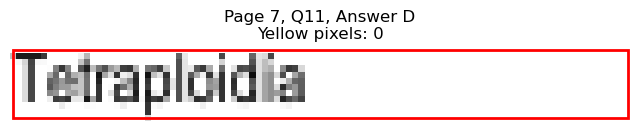


Page 7, Q11 - Selected Answer: C (based on yellow pixel count)




Page 7, Q12 - A: Detected box: x0=68.3, y0=722.2, x1=118.4, y1=733.3
Page 7, Q12, A: Yellow pixels: 0
Page 7, Q12, A: Total non-white pixels: 253
Page 7, Q12, A: Yellow percentage: 0.0%


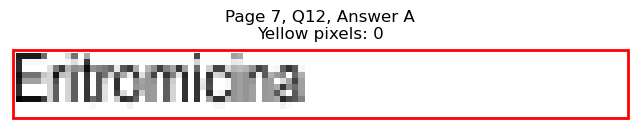

Page 7, Q12 - B: Detected box: x0=68.3, y0=734.8, x1=113.9, y1=745.9
Page 7, Q12, B: Yellow pixels: 0
Page 7, Q12, B: Total non-white pixels: 221
Page 7, Q12, B: Yellow percentage: 0.0%


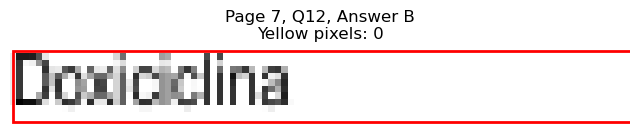

Page 7, Q12 - C: Detected box: x0=327.5, y0=722.2, x1=375.6, y1=733.3
Page 7, Q12, C: Yellow pixels: 925
Page 7, Q12, C: Total non-white pixels: 1188
Page 7, Q12, C: Yellow percentage: 77.9%


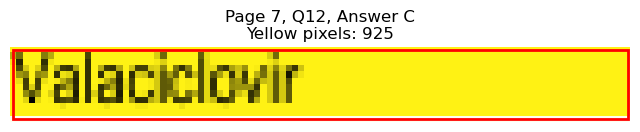

Page 7, Q12 - D: Detected box: x0=327.5, y0=734.8, x1=367.2, y1=745.9
Page 7, Q12, D: Yellow pixels: 0
Page 7, Q12, D: Total non-white pixels: 230
Page 7, Q12, D: Yellow percentage: 0.0%


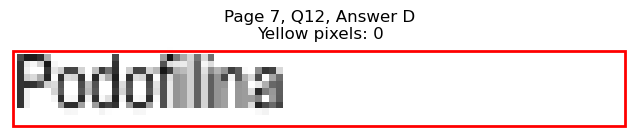


Page 7, Q12 - Selected Answer: C (based on yellow pixel count)





Page 8: Found 10 questions
Page 8, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=165.6, y1=114.8
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 508
Page 8, Q1, A: Yellow percentage: 0.0%


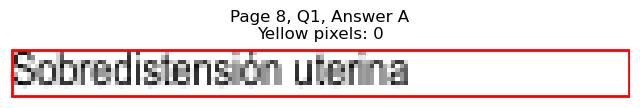

Page 8, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=183.6, y1=127.4
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 581
Page 8, Q1, B: Yellow percentage: 0.0%


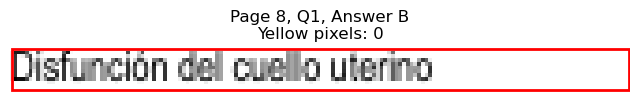

Page 8, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=424.8, y1=114.8
Page 8, Q1, C: Yellow pixels: 1418
Page 8, Q1, C: Total non-white pixels: 1776
Page 8, Q1, C: Yellow percentage: 79.8%


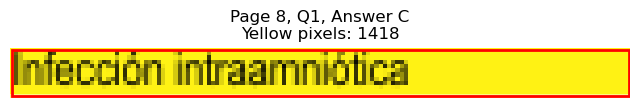

Page 8, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=423.2, y1=127.4
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 471
Page 8, Q1, D: Yellow percentage: 0.0%


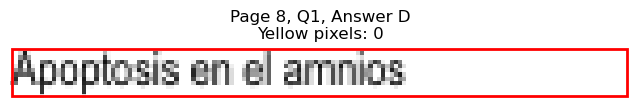


Page 8, Q1 - Selected Answer: C (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=68.3, y0=179.5, x1=118.4, y1=190.5
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 259
Page 8, Q2, A: Yellow percentage: 0.0%


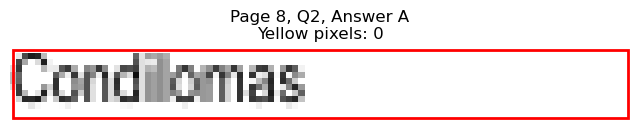

Page 8, Q2 - B: Detected box: x0=68.3, y0=192.1, x1=123.0, y1=203.1
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 246
Page 8, Q2, B: Yellow percentage: 0.0%


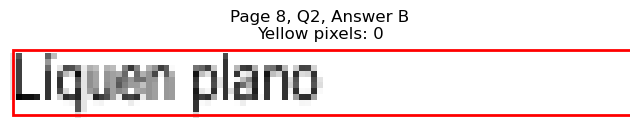

Page 8, Q2 - C: Detected box: x0=327.5, y0=179.5, x1=393.7, y1=190.5
Page 8, Q2, C: Yellow pixels: 1044
Page 8, Q2, C: Total non-white pixels: 1404
Page 8, Q2, C: Yellow percentage: 74.4%


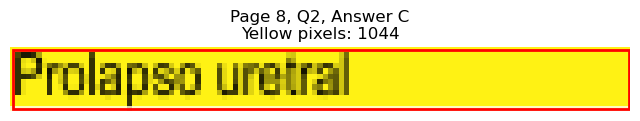

Page 8, Q2 - D: Detected box: x0=327.5, y0=192.1, x1=409.8, y1=203.1
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 425
Page 8, Q2, D: Yellow percentage: 0.0%


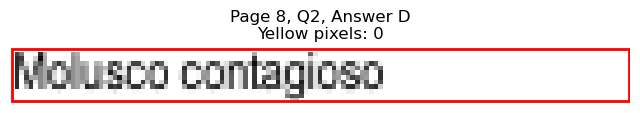


Page 8, Q2 - Selected Answer: C (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=68.3, y0=242.6, x1=201.7, y1=253.6
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 662
Page 8, Q3, A: Yellow percentage: 0.0%


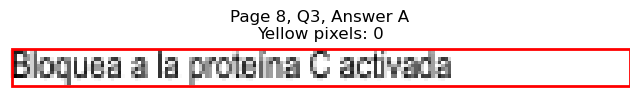

Page 8, Q3 - B: Detected box: x0=68.3, y0=255.2, x1=314.5, y1=266.2
Page 8, Q3, B: Yellow pixels: 297
Page 8, Q3, B: Total non-white pixels: 1493
Page 8, Q3, B: Yellow percentage: 19.9%


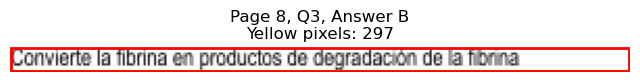

Page 8, Q3 - C: Detected box: x0=68.8, y0=267.8, x1=243.2, y1=278.8
Page 8, Q3, C: Yellow pixels: 2054
Page 8, Q3, C: Total non-white pixels: 2712
Page 8, Q3, C: Yellow percentage: 75.7%


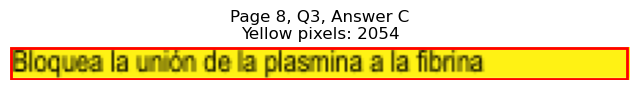

Page 8, Q3 - D: Detected box: x0=68.8, y0=280.5, x1=213.7, y1=291.6
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 703
Page 8, Q3, D: Yellow percentage: 0.0%


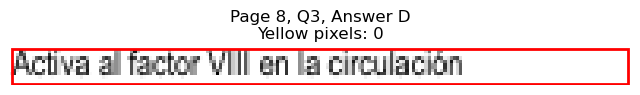


Page 8, Q3 - Selected Answer: C (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=68.3, y0=318.3, x1=158.5, y1=329.4
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 477
Page 8, Q4, A: Yellow percentage: 0.0%


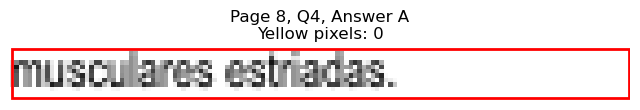

Page 8, Q4 - B: Detected box: x0=68.3, y0=330.9, x1=113.9, y1=342.0
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 214
Page 8, Q4, B: Yellow percentage: 0.0%


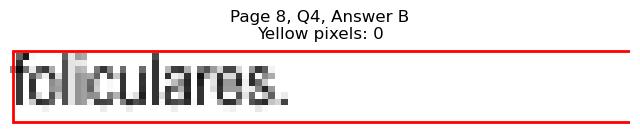

Page 8, Q4 - C: Detected box: x0=327.5, y0=318.3, x1=387.1, y1=329.4
Page 8, Q4, C: Yellow pixels: 982
Page 8, Q4, C: Total non-white pixels: 1332
Page 8, Q4, C: Yellow percentage: 73.7%


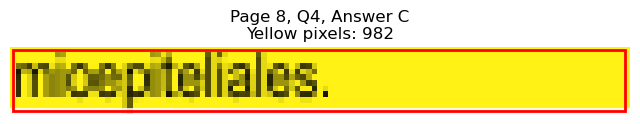

Page 8, Q4 - D: Detected box: x0=327.5, y0=330.9, x1=385.7, y1=342.0
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 310
Page 8, Q4, D: Yellow percentage: 0.0%


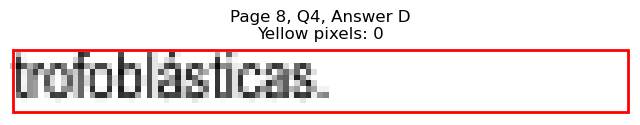


Page 8, Q4 - Selected Answer: C (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=68.3, y0=394.0, x1=199.1, y1=405.1
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 657
Page 8, Q5, A: Yellow percentage: 0.0%


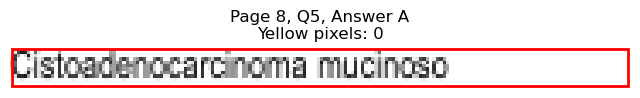

Page 8, Q5 - B: Detected box: x0=68.3, y0=406.6, x1=174.1, y1=417.7
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 522
Page 8, Q5, B: Yellow percentage: 0.0%


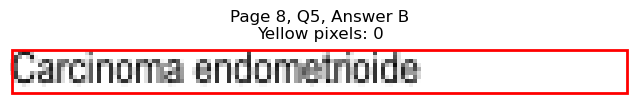

Page 8, Q5 - C: Detected box: x0=327.5, y0=394.0, x1=403.2, y1=405.1
Page 8, Q5, C: Yellow pixels: 127
Page 8, Q5, C: Total non-white pixels: 611
Page 8, Q5, C: Yellow percentage: 20.8%


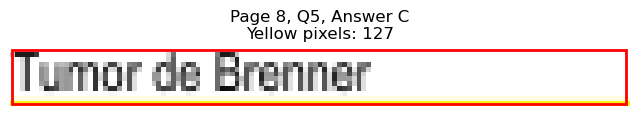

Page 8, Q5 - D: Detected box: x0=327.5, y0=406.6, x1=446.9, y1=417.7
Page 8, Q5, D: Yellow pixels: 1575
Page 8, Q5, D: Total non-white pixels: 2040
Page 8, Q5, D: Yellow percentage: 77.2%


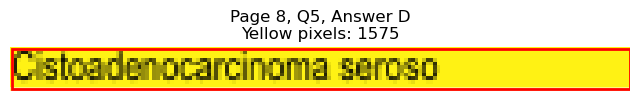


Page 8, Q5 - Selected Answer: D (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=68.3, y0=482.5, x1=189.7, y1=493.5
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 633
Page 8, Q6, A: Yellow percentage: 0.0%


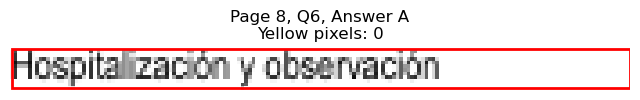

Page 8, Q6 - B: Detected box: x0=68.3, y0=495.1, x1=159.6, y1=506.1
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 428
Page 8, Q6, B: Yellow percentage: 0.0%


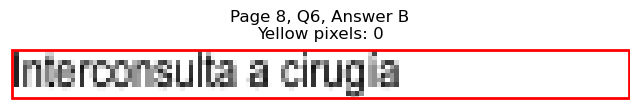

Page 8, Q6 - C: Detected box: x0=327.5, y0=482.5, x1=426.8, y1=493.5
Page 8, Q6, C: Yellow pixels: 1293
Page 8, Q6, C: Total non-white pixels: 1800
Page 8, Q6, C: Yellow percentage: 71.8%


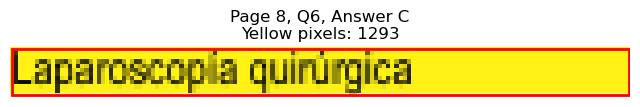

Page 8, Q6 - D: Detected box: x0=327.5, y0=495.1, x1=419.8, y1=506.1
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 505
Page 8, Q6, D: Yellow percentage: 0.0%


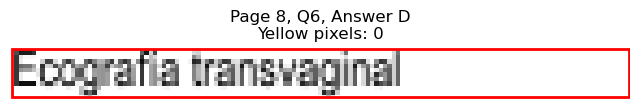


Page 8, Q6 - Selected Answer: C (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=68.3, y0=558.2, x1=167.0, y1=569.2
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 494
Page 8, Q7, A: Yellow percentage: 0.0%


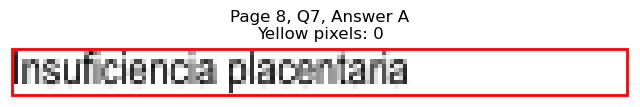

Page 8, Q7 - B: Detected box: x0=68.3, y0=570.8, x1=251.8, y1=581.8
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 955
Page 8, Q7, B: Yellow percentage: 0.0%


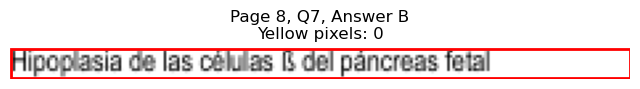

Page 8, Q7 - C: Detected box: x0=327.5, y0=558.2, x1=379.7, y1=569.2
Page 8, Q7, C: Yellow pixels: 935
Page 8, Q7, C: Total non-white pixels: 1133
Page 8, Q7, C: Yellow percentage: 82.5%


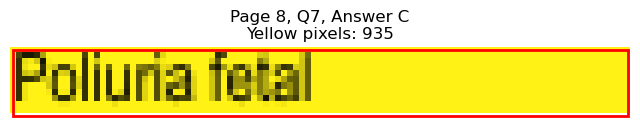

Page 8, Q7 - D: Detected box: x0=327.5, y0=570.8, x1=500.0, y1=581.8
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 862
Page 8, Q7, D: Yellow percentage: 0.0%


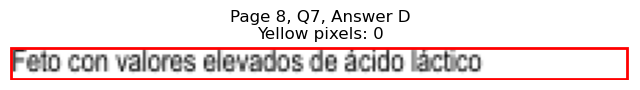


Page 8, Q7 - Selected Answer: C (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=68.3, y0=608.6, x1=130.4, y1=619.6
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 260
Page 8, Q8, A: Yellow percentage: 0.0%


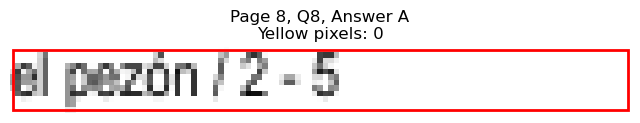

Page 8, Q8 - B: Detected box: x0=68.3, y0=621.3, x1=174.1, y1=632.4
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 472
Page 8, Q8, B: Yellow percentage: 0.0%


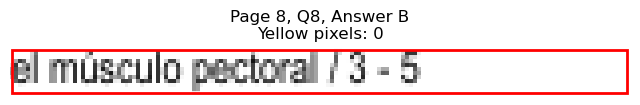

Page 8, Q8 - C: Detected box: x0=327.5, y0=608.6, x1=383.6, y1=619.6
Page 8, Q8, C: Yellow pixels: 1127
Page 8, Q8, C: Total non-white pixels: 1284
Page 8, Q8, C: Yellow percentage: 87.8%


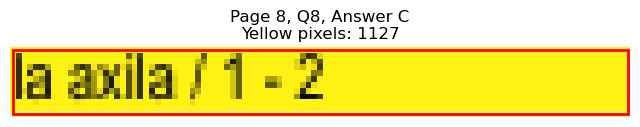

Page 8, Q8 - D: Detected box: x0=327.5, y0=621.3, x1=405.2, y1=632.4
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 344
Page 8, Q8, D: Yellow percentage: 0.0%


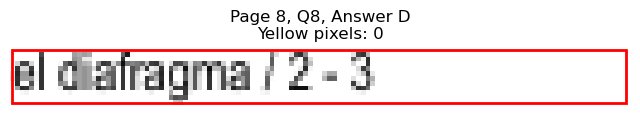


Page 8, Q8 - Selected Answer: C (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=68.3, y0=659.1, x1=119.9, y1=670.2
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 280
Page 8, Q9, A: Yellow percentage: 0.0%


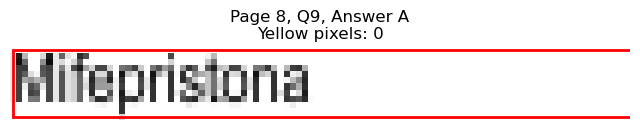

Page 8, Q9 - B: Detected box: x0=68.3, y0=671.7, x1=115.4, y1=682.8
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 234
Page 8, Q9, B: Yellow percentage: 0.0%


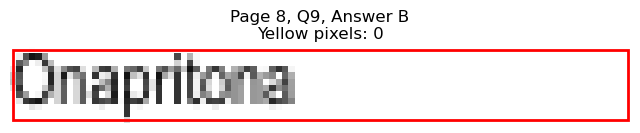

Page 8, Q9 - C: Detected box: x0=327.5, y0=659.1, x1=374.2, y1=670.2
Page 8, Q9, C: Yellow pixels: 98
Page 8, Q9, C: Total non-white pixels: 423
Page 8, Q9, C: Yellow percentage: 23.2%


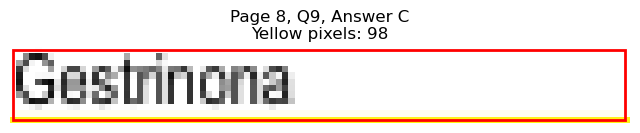

Page 8, Q9 - D: Detected box: x0=327.5, y0=671.7, x1=415.2, y1=682.8
Page 8, Q9, D: Yellow pixels: 1302
Page 8, Q9, D: Total non-white pixels: 1668
Page 8, Q9, D: Yellow percentage: 78.1%


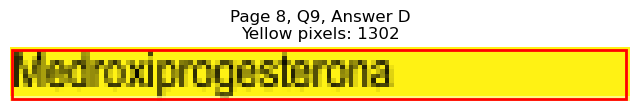


Page 8, Q9 - Selected Answer: D (based on yellow pixel count)




Page 8, Q10 - A: Detected box: x0=56.6, y0=734.8, x1=65.2, y1=745.9
Page 8, Q10, A: Yellow pixels: 0
Page 8, Q10, A: Total non-white pixels: 129
Page 8, Q10, A: Yellow percentage: 0.0%


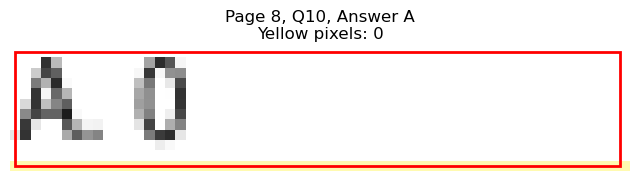

Page 8, Q10 - B: Detected box: x0=56.6, y0=747.4, x1=65.2, y1=758.5
Page 8, Q10, B: Yellow pixels: 605
Page 8, Q10, B: Total non-white pixels: 720
Page 8, Q10, B: Yellow percentage: 84.0%


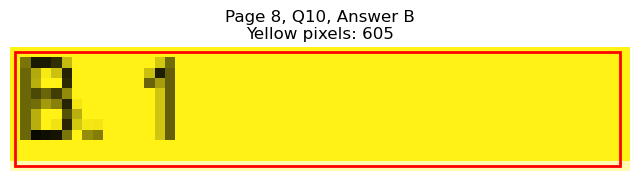

Page 8, Q10 - C: Detected box: x0=315.4, y0=734.8, x1=324.4, y1=745.9
Page 8, Q10, C: Yellow pixels: 0
Page 8, Q10, C: Total non-white pixels: 64
Page 8, Q10, C: Yellow percentage: 0.0%


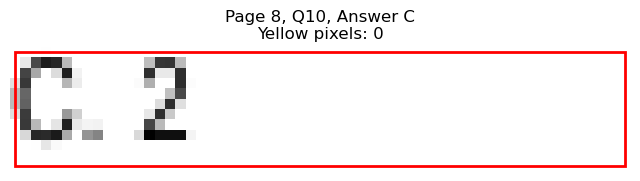

Page 8, Q10 - D: Detected box: x0=315.4, y0=747.4, x1=324.4, y1=758.5
Page 8, Q10, D: Yellow pixels: 0
Page 8, Q10, D: Total non-white pixels: 72
Page 8, Q10, D: Yellow percentage: 0.0%


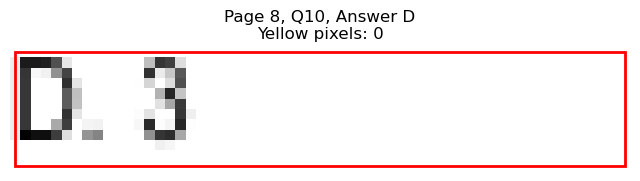


Page 8, Q10 - Selected Answer: B (based on yellow pixel count)





Page 9: Found 10 questions
Page 9, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=110.9, y1=114.8
Page 9, Q1, A: Yellow pixels: 952
Page 9, Q1, A: Total non-white pixels: 1116
Page 9, Q1, A: Yellow percentage: 85.3%


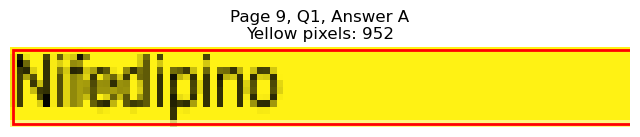

Page 9, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=115.9, y1=127.4
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 244
Page 9, Q1, B: Yellow percentage: 0.0%


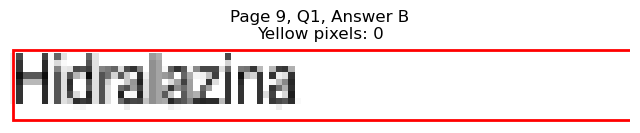

Page 9, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=387.1, y1=114.8
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 300
Page 9, Q1, C: Yellow percentage: 0.0%


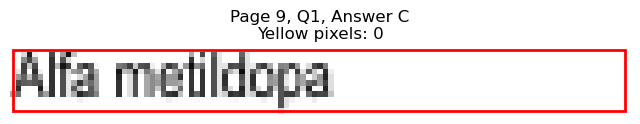

Page 9, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=366.6, y1=127.4
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 196
Page 9, Q1, D: Yellow percentage: 0.0%


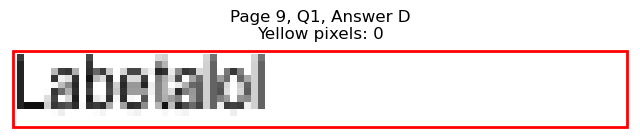


Page 9, Q1 - Selected Answer: A (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=68.3, y0=154.3, x1=216.2, y1=165.3
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 719
Page 9, Q2, A: Yellow percentage: 0.0%


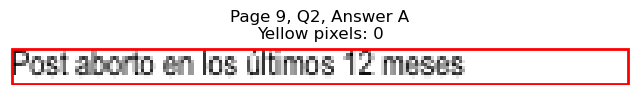

Page 9, Q2 - B: Detected box: x0=68.3, y0=166.9, x1=124.9, y1=177.9
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 298
Page 9, Q2, B: Yellow percentage: 0.0%


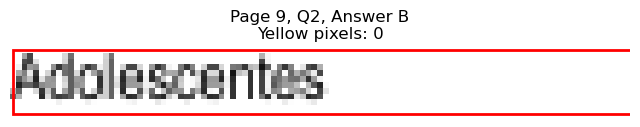

Page 9, Q2 - C: Detected box: x0=327.5, y0=154.3, x1=427.8, y1=165.3
Page 9, Q2, C: Yellow pixels: 151
Page 9, Q2, C: Total non-white pixels: 666
Page 9, Q2, C: Yellow percentage: 22.7%


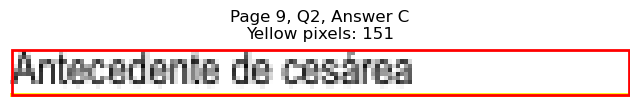

Page 9, Q2 - D: Detected box: x0=327.5, y0=166.9, x1=422.8, y1=177.9
Page 9, Q2, D: Yellow pixels: 1394
Page 9, Q2, D: Total non-white pixels: 1752
Page 9, Q2, D: Yellow percentage: 79.6%


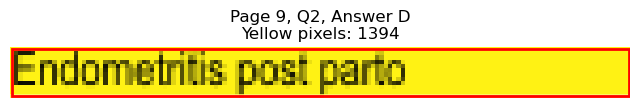


Page 9, Q2 - Selected Answer: D (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=68.3, y0=230.0, x1=126.0, y1=241.0
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 309
Page 9, Q3, A: Yellow percentage: 0.0%


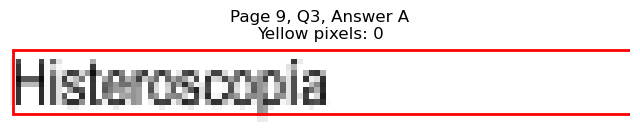

Page 9, Q3 - B: Detected box: x0=68.3, y0=242.6, x1=134.0, y1=253.6
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 314
Page 9, Q3, B: Yellow percentage: 0.0%


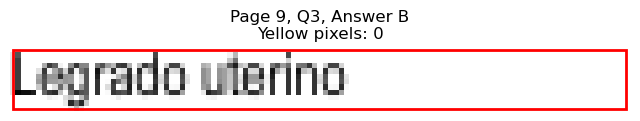

Page 9, Q3 - C: Detected box: x0=327.5, y0=230.0, x1=419.8, y1=241.0
Page 9, Q3, C: Yellow pixels: 143
Page 9, Q3, C: Total non-white pixels: 755
Page 9, Q3, C: Yellow percentage: 18.9%


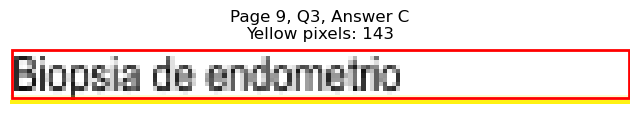

Page 9, Q3 - D: Detected box: x0=327.5, y0=242.6, x1=419.8, y1=253.6
Page 9, Q3, D: Yellow pixels: 1204
Page 9, Q3, D: Total non-white pixels: 1716
Page 9, Q3, D: Yellow percentage: 70.2%


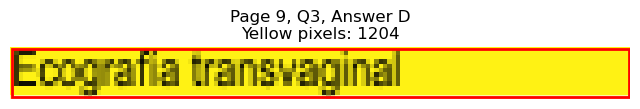


Page 9, Q3 - Selected Answer: D (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=68.3, y0=293.1, x1=120.5, y1=304.2
Page 9, Q4, A: Yellow pixels: 951
Page 9, Q4, A: Total non-white pixels: 1134
Page 9, Q4, A: Yellow percentage: 83.9%


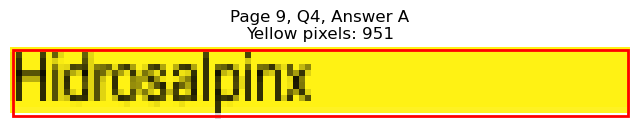

Page 9, Q4 - B: Detected box: x0=68.3, y0=305.7, x1=129.5, y1=316.8
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 306
Page 9, Q4, B: Yellow percentage: 0.0%


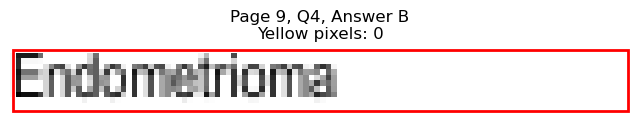

Page 9, Q4 - C: Detected box: x0=327.5, y0=293.1, x1=368.6, y1=304.2
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 204
Page 9, Q4, C: Yellow percentage: 0.0%


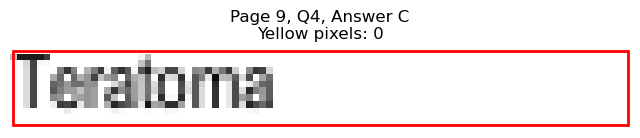

Page 9, Q4 - D: Detected box: x0=327.5, y0=305.7, x1=388.2, y1=316.8
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 324
Page 9, Q4, D: Yellow percentage: 0.0%


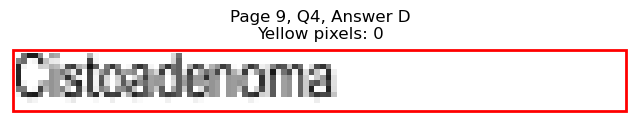


Page 9, Q4 - Selected Answer: A (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=68.3, y0=343.6, x1=187.7, y1=354.7
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 592
Page 9, Q5, A: Yellow percentage: 0.0%


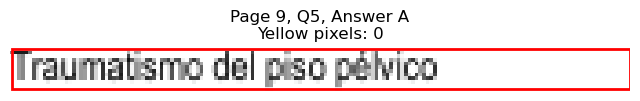

Page 9, Q5 - B: Detected box: x0=68.3, y0=356.2, x1=120.0, y1=367.3
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 283
Page 9, Q5, B: Yellow percentage: 0.0%


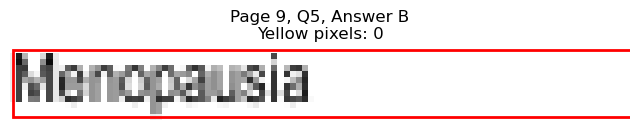

Page 9, Q5 - C: Detected box: x0=327.5, y0=343.6, x1=516.6, y1=354.7
Page 9, Q5, C: Yellow pixels: 213
Page 9, Q5, C: Total non-white pixels: 1157
Page 9, Q5, C: Yellow percentage: 18.4%


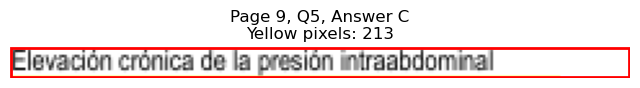

Page 9, Q5 - D: Detected box: x0=327.5, y0=356.2, x1=382.7, y1=367.3
Page 9, Q5, D: Yellow pixels: 957
Page 9, Q5, D: Total non-white pixels: 1272
Page 9, Q5, D: Yellow percentage: 75.2%


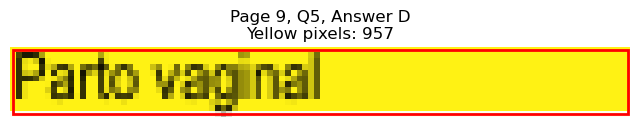


Page 9, Q5 - Selected Answer: D (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=68.3, y0=432.0, x1=227.8, y1=443.0
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 773
Page 9, Q6, A: Yellow percentage: 0.0%


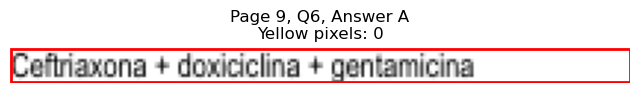

Page 9, Q6 - B: Detected box: x0=68.3, y0=444.6, x1=181.3, y1=455.6
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 583
Page 9, Q6, B: Yellow percentage: 0.0%


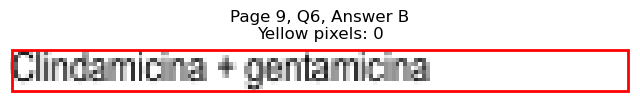

Page 9, Q6 - C: Detected box: x0=327.5, y0=432.0, x1=489.5, y1=443.0
Page 9, Q6, C: Yellow pixels: 1969
Page 9, Q6, C: Total non-white pixels: 2556
Page 9, Q6, C: Yellow percentage: 77.0%


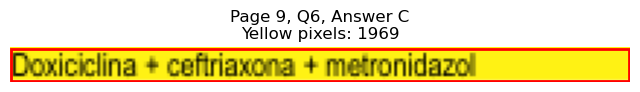

Page 9, Q6 - D: Detected box: x0=327.5, y0=444.6, x1=431.5, y1=455.6
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 504
Page 9, Q6, D: Yellow percentage: 0.0%


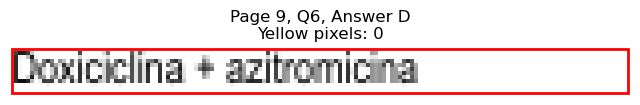


Page 9, Q6 - Selected Answer: C (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=68.3, y0=495.1, x1=192.1, y1=506.1
Page 9, Q7, A: Yellow pixels: 175
Page 9, Q7, A: Total non-white pixels: 939
Page 9, Q7, A: Yellow percentage: 18.6%


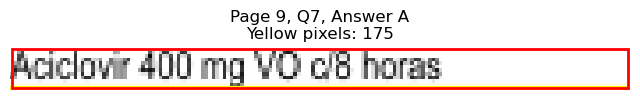

Page 9, Q7 - B: Detected box: x0=68.3, y0=507.7, x1=198.2, y1=518.7
Page 9, Q7, B: Yellow pixels: 1706
Page 9, Q7, B: Total non-white pixels: 2172
Page 9, Q7, B: Yellow percentage: 78.5%


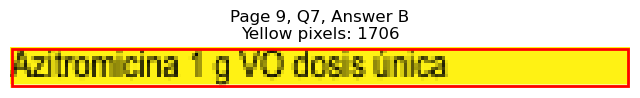

Page 9, Q7 - C: Detected box: x0=68.8, y0=520.3, x1=295.4, y1=531.3
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 1062
Page 9, Q7, C: Yellow percentage: 0.0%


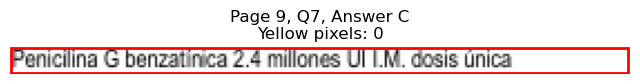

Page 9, Q7 - D: Detected box: x0=68.8, y0=532.9, x1=192.1, y1=543.9
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 554
Page 9, Q7, D: Yellow percentage: 0.0%


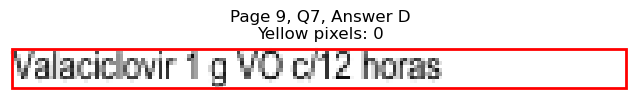


Page 9, Q7 - Selected Answer: B (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=68.3, y0=583.4, x1=105.0, y1=594.4
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 162
Page 9, Q8, A: Yellow percentage: 0.0%


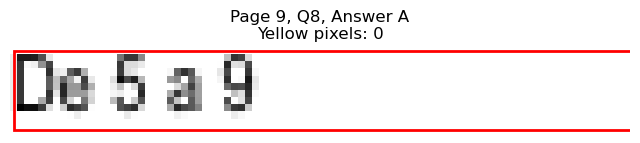

Page 9, Q8 - B: Detected box: x0=68.3, y0=596.0, x1=115.1, y1=607.0
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 181
Page 9, Q8, B: Yellow percentage: 0.0%


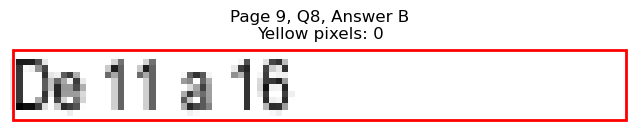

Page 9, Q8 - C: Detected box: x0=327.5, y0=583.4, x1=374.3, y1=594.4
Page 9, Q8, C: Yellow pixels: 98
Page 9, Q8, C: Total non-white pixels: 286
Page 9, Q8, C: Yellow percentage: 34.3%


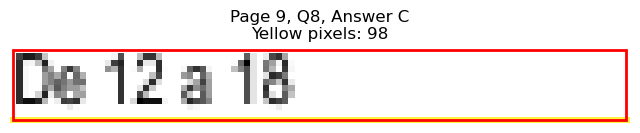

Page 9, Q8 - D: Detected box: x0=327.5, y0=596.0, x1=369.2, y1=607.0
Page 9, Q8, D: Yellow pixels: 1005
Page 9, Q8, D: Total non-white pixels: 1116
Page 9, Q8, D: Yellow percentage: 90.1%


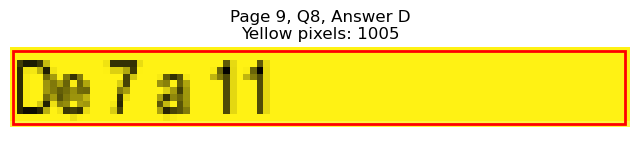


Page 9, Q8 - Selected Answer: D (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=68.3, y0=633.9, x1=98.4, y1=645.0
Page 9, Q9, A: Yellow pixels: 843
Page 9, Q9, A: Total non-white pixels: 972
Page 9, Q9, A: Yellow percentage: 86.7%


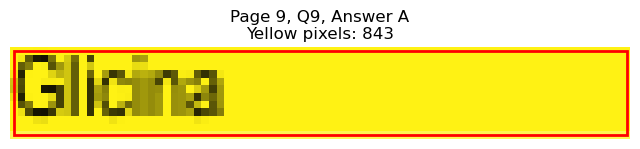

Page 9, Q9 - B: Detected box: x0=68.3, y0=646.5, x1=130.4, y1=657.6
Page 9, Q9, B: Yellow pixels: 0
Page 9, Q9, B: Total non-white pixels: 348
Page 9, Q9, B: Yellow percentage: 0.0%


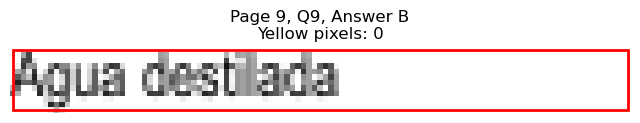

Page 9, Q9 - C: Detected box: x0=327.5, y0=633.9, x1=366.6, y1=645.0
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 197
Page 9, Q9, C: Yellow percentage: 0.0%


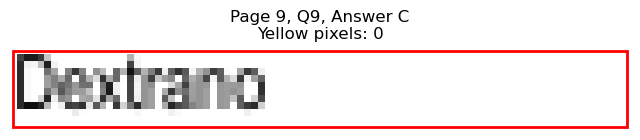

Page 9, Q9 - D: Detected box: x0=327.5, y0=646.5, x1=341.0, y1=657.6
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 84
Page 9, Q9, D: Yellow percentage: 0.0%


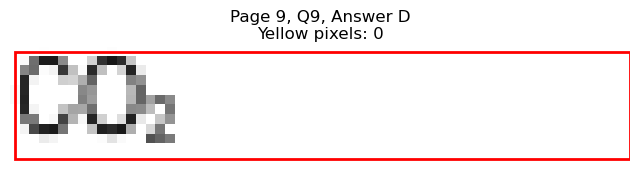


Page 9, Q9 - Selected Answer: A (based on yellow pixel count)




Page 9, Q10 - A: Detected box: x0=68.3, y0=697.0, x1=115.9, y1=708.1
Page 9, Q10, A: Yellow pixels: 0
Page 9, Q10, A: Total non-white pixels: 245
Page 9, Q10, A: Yellow percentage: 0.0%


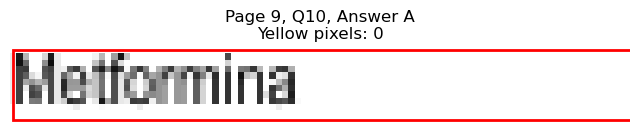

Page 9, Q10 - B: Detected box: x0=68.3, y0=709.6, x1=135.5, y1=720.7
Page 9, Q10, B: Yellow pixels: 0
Page 9, Q10, B: Total non-white pixels: 370
Page 9, Q10, B: Yellow percentage: 0.0%


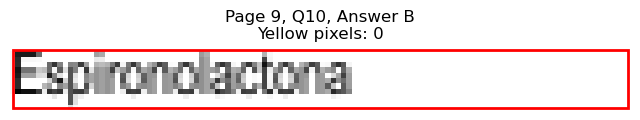

Page 9, Q10 - C: Detected box: x0=327.5, y0=697.0, x1=471.4, y1=708.1
Page 9, Q10, C: Yellow pixels: 1605
Page 9, Q10, C: Total non-white pixels: 2147
Page 9, Q10, C: Yellow percentage: 74.8%


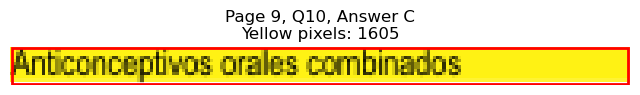

Page 9, Q10 - D: Detected box: x0=327.5, y0=709.6, x1=372.2, y1=720.7
Page 9, Q10, D: Yellow pixels: 0
Page 9, Q10, D: Total non-white pixels: 262
Page 9, Q10, D: Yellow percentage: 0.0%


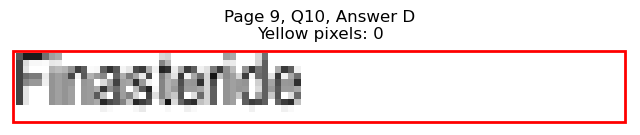


Page 9, Q10 - Selected Answer: C (based on yellow pixel count)





Page 10: Found 10 questions
Page 10, Q1 - A: Detected box: x0=68.3, y0=116.4, x1=124.9, y1=127.4
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 295
Page 10, Q1, A: Yellow percentage: 0.0%


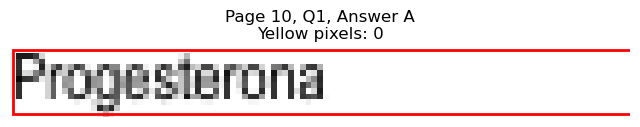

Page 10, Q1 - B: Detected box: x0=68.3, y0=129.0, x1=155.5, y1=140.0
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 433
Page 10, Q1, B: Yellow percentage: 0.0%


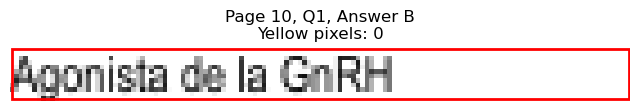

Page 10, Q1 - C: Detected box: x0=327.5, y0=116.4, x1=444.4, y1=127.4
Page 10, Q1, C: Yellow pixels: 1420
Page 10, Q1, C: Total non-white pixels: 2016
Page 10, Q1, C: Yellow percentage: 70.4%


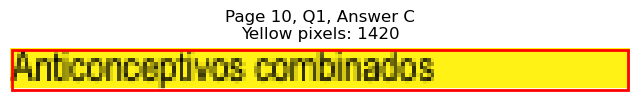

Page 10, Q1 - D: Detected box: x0=327.5, y0=129.0, x1=427.3, y1=140.0
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 515
Page 10, Q1, D: Yellow percentage: 0.0%


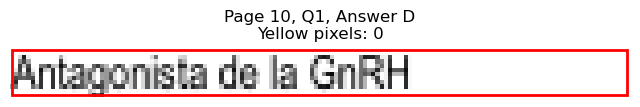


Page 10, Q1 - Selected Answer: C (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=68.3, y0=192.1, x1=160.6, y1=203.1
Page 10, Q2, A: Yellow pixels: 143
Page 10, Q2, A: Total non-white pixels: 783
Page 10, Q2, A: Yellow percentage: 18.3%


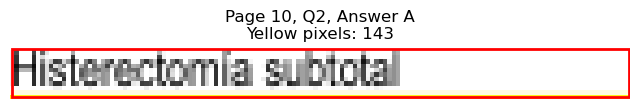

Page 10, Q2 - B: Detected box: x0=68.3, y0=204.7, x1=115.4, y1=215.7
Page 10, Q2, B: Yellow pixels: 1003
Page 10, Q2, B: Total non-white pixels: 1176
Page 10, Q2, B: Yellow percentage: 85.3%


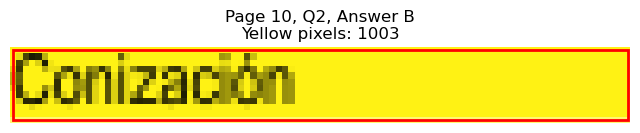

Page 10, Q2 - C: Detected box: x0=327.5, y0=192.1, x1=480.4, y1=203.1
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 811
Page 10, Q2, C: Yellow percentage: 0.0%


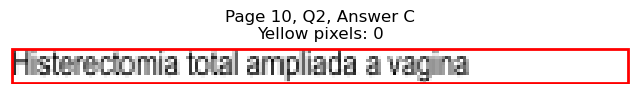

Page 10, Q2 - D: Detected box: x0=327.5, y0=204.7, x1=374.2, y1=215.7
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 251
Page 10, Q2, D: Yellow percentage: 0.0%


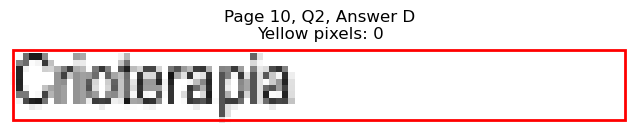


Page 10, Q2 - Selected Answer: B (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=68.3, y0=242.6, x1=241.9, y1=253.6
Page 10, Q3, A: Yellow pixels: 0
Page 10, Q3, A: Total non-white pixels: 841
Page 10, Q3, A: Yellow percentage: 0.0%


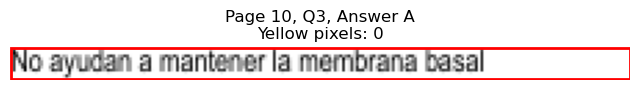

Page 10, Q3 - B: Detected box: x0=68.3, y0=255.2, x1=179.2, y1=266.2
Page 10, Q3, B: Yellow pixels: 162
Page 10, Q3, B: Total non-white pixels: 697
Page 10, Q3, B: Yellow percentage: 23.2%


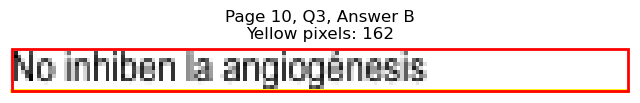

Page 10, Q3 - C: Detected box: x0=68.8, y0=267.8, x1=315.1, y1=278.8
Page 10, Q3, C: Yellow pixels: 2648
Page 10, Q3, C: Total non-white pixels: 3576
Page 10, Q3, C: Yellow percentage: 74.0%


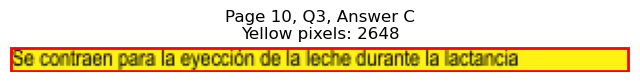

Page 10, Q3 - D: Detected box: x0=68.8, y0=280.5, x1=223.2, y1=291.6
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 739
Page 10, Q3, D: Yellow percentage: 0.0%


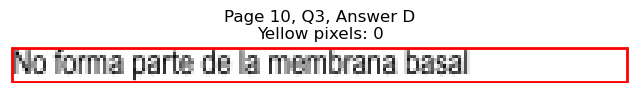


Page 10, Q3 - Selected Answer: C (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=68.3, y0=318.3, x1=153.0, y1=329.4
Page 10, Q4, A: Yellow pixels: 135
Page 10, Q4, A: Total non-white pixels: 569
Page 10, Q4, A: Yellow percentage: 23.7%


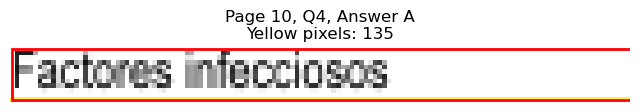

Page 10, Q4 - B: Detected box: x0=68.3, y0=330.9, x1=109.4, y1=342.0
Page 10, Q4, B: Yellow pixels: 935
Page 10, Q4, B: Total non-white pixels: 1104
Page 10, Q4, B: Yellow percentage: 84.7%


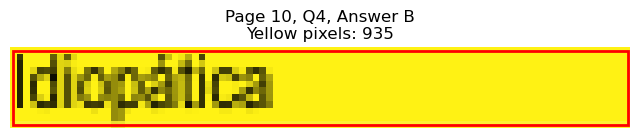

Page 10, Q4 - C: Detected box: x0=327.5, y0=318.3, x1=381.1, y1=329.4
Page 10, Q4, C: Yellow pixels: 0
Page 10, Q4, C: Total non-white pixels: 297
Page 10, Q4, C: Yellow percentage: 0.0%


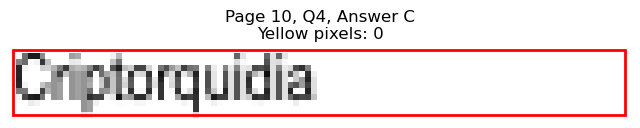

Page 10, Q4 - D: Detected box: x0=327.5, y0=330.9, x1=426.2, y1=342.0
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 507
Page 10, Q4, D: Yellow percentage: 0.0%


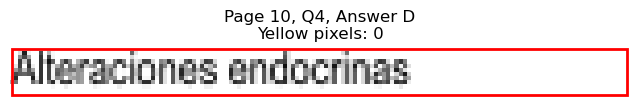


Page 10, Q4 - Selected Answer: B (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=68.3, y0=381.4, x1=185.2, y1=392.5
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 643
Page 10, Q5, A: Yellow percentage: 0.0%


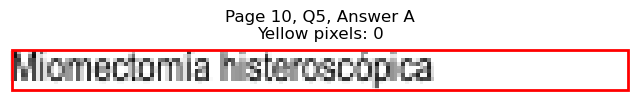

Page 10, Q5 - B: Detected box: x0=68.3, y0=394.0, x1=180.1, y1=405.1
Page 10, Q5, B: Yellow pixels: 0
Page 10, Q5, B: Total non-white pixels: 571
Page 10, Q5, B: Yellow percentage: 0.0%


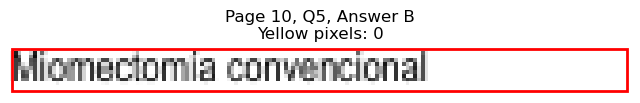

Page 10, Q5 - C: Detected box: x0=327.5, y0=381.4, x1=442.3, y1=392.5
Page 10, Q5, C: Yellow pixels: 1370
Page 10, Q5, C: Total non-white pixels: 1992
Page 10, Q5, C: Yellow percentage: 68.8%


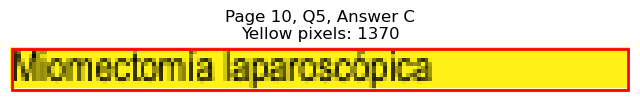

Page 10, Q5 - D: Detected box: x0=327.5, y0=394.0, x1=420.2, y1=405.1
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 499
Page 10, Q5, D: Yellow percentage: 0.0%


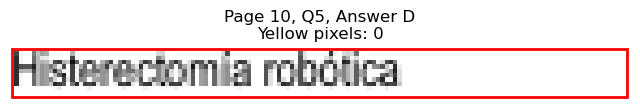


Page 10, Q5 - Selected Answer: C (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=68.3, y0=432.0, x1=122.4, y1=443.0
Page 10, Q6, A: Yellow pixels: 0
Page 10, Q6, A: Total non-white pixels: 395
Page 10, Q6, A: Yellow percentage: 0.0%


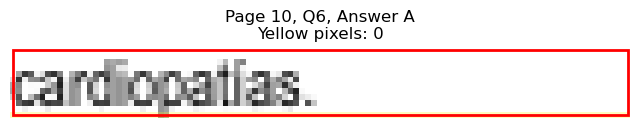

Page 10, Q6 - B: Detected box: x0=68.3, y0=444.6, x1=124.4, y1=455.6
Page 10, Q6, B: Yellow pixels: 976
Page 10, Q6, B: Total non-white pixels: 1284
Page 10, Q6, B: Yellow percentage: 76.0%


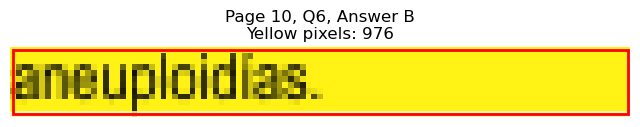

Page 10, Q6 - C: Detected box: x0=327.5, y0=432.0, x1=428.8, y1=443.0
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 500
Page 10, Q6, C: Yellow percentage: 0.0%


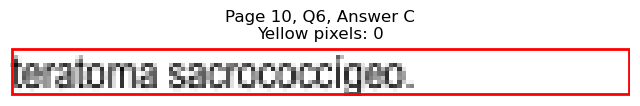

Page 10, Q6 - D: Detected box: x0=327.5, y0=444.6, x1=416.8, y1=455.6
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 417
Page 10, Q6, D: Yellow percentage: 0.0%


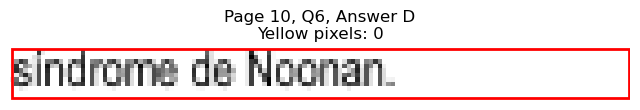


Page 10, Q6 - Selected Answer: B (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=68.3, y0=520.3, x1=174.6, y1=531.3
Page 10, Q7, A: Yellow pixels: 0
Page 10, Q7, A: Total non-white pixels: 520
Page 10, Q7, A: Yellow percentage: 0.0%


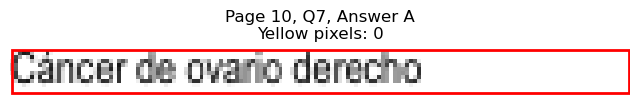

Page 10, Q7 - B: Detected box: x0=68.3, y0=532.9, x1=209.8, y1=543.9
Page 10, Q7, B: Yellow pixels: 0
Page 10, Q7, B: Total non-white pixels: 707
Page 10, Q7, B: Yellow percentage: 0.0%


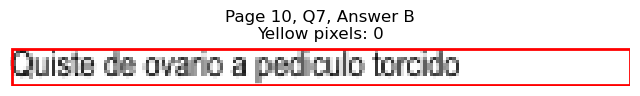

Page 10, Q7 - C: Detected box: x0=327.5, y0=520.3, x1=412.2, y1=531.3
Page 10, Q7, C: Yellow pixels: 136
Page 10, Q7, C: Total non-white pixels: 577
Page 10, Q7, C: Yellow percentage: 23.6%


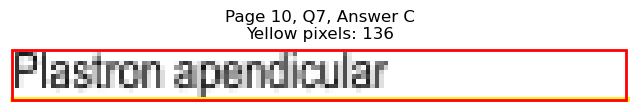

Page 10, Q7 - D: Detected box: x0=327.5, y0=532.9, x1=448.9, y1=543.9
Page 10, Q7, D: Yellow pixels: 1606
Page 10, Q7, D: Total non-white pixels: 2064
Page 10, Q7, D: Yellow percentage: 77.8%


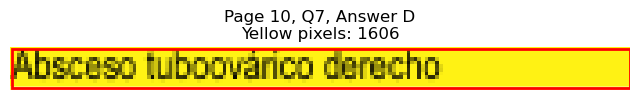


Page 10, Q7 - Selected Answer: D (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=68.3, y0=596.0, x1=167.0, y1=607.0
Page 10, Q8, A: Yellow pixels: 150
Page 10, Q8, A: Total non-white pixels: 800
Page 10, Q8, A: Yellow percentage: 18.8%


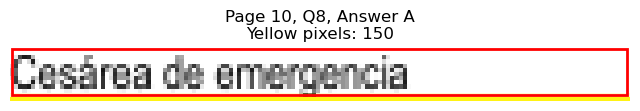

Page 10, Q8 - B: Detected box: x0=68.3, y0=608.6, x1=187.7, y1=619.6
Page 10, Q8, B: Yellow pixels: 1598
Page 10, Q8, B: Total non-white pixels: 2040
Page 10, Q8, B: Yellow percentage: 78.3%


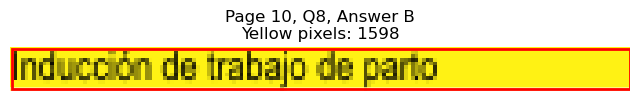

Page 10, Q8 - C: Detected box: x0=327.5, y0=596.0, x1=447.8, y1=607.0
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 595
Page 10, Q8, C: Yellow percentage: 0.0%


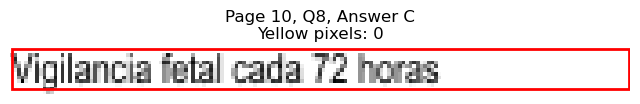

Page 10, Q8 - D: Detected box: x0=327.5, y0=608.6, x1=437.3, y1=619.6
Page 10, Q8, D: Yellow pixels: 0
Page 10, Q8, D: Total non-white pixels: 530
Page 10, Q8, D: Yellow percentage: 0.0%


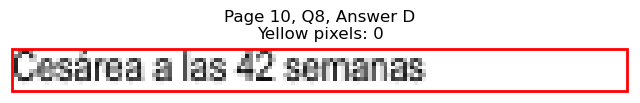


Page 10, Q8 - Selected Answer: B (based on yellow pixel count)




Page 10, Q9 - A: Detected box: x0=68.3, y0=659.1, x1=80.9, y1=670.2
Page 10, Q9, A: Yellow pixels: 652
Page 10, Q9, A: Total non-white pixels: 693
Page 10, Q9, A: Yellow percentage: 94.1%


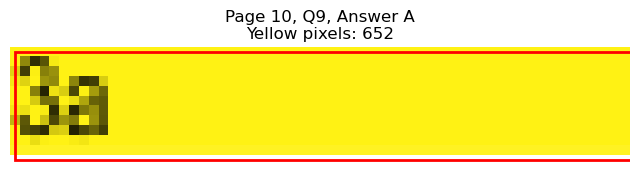

Page 10, Q9 - B: Detected box: x0=68.3, y0=671.7, x1=80.9, y1=682.8
Page 10, Q9, B: Yellow pixels: 0
Page 10, Q9, B: Total non-white pixels: 61
Page 10, Q9, B: Yellow percentage: 0.0%


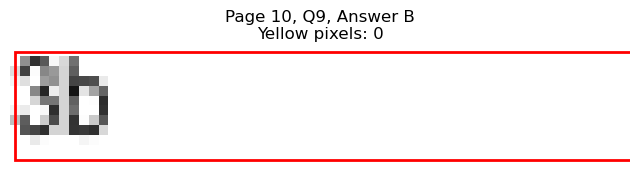

Page 10, Q9 - C: Detected box: x0=327.5, y0=659.1, x1=339.5, y1=670.2
Page 10, Q9, C: Yellow pixels: 0
Page 10, Q9, C: Total non-white pixels: 54
Page 10, Q9, C: Yellow percentage: 0.0%


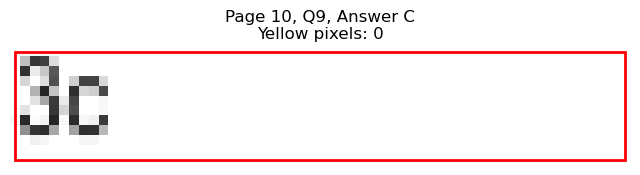

Page 10, Q9 - D: Detected box: x0=327.5, y0=671.7, x1=340.1, y1=682.8
Page 10, Q9, D: Yellow pixels: 0
Page 10, Q9, D: Total non-white pixels: 55
Page 10, Q9, D: Yellow percentage: 0.0%


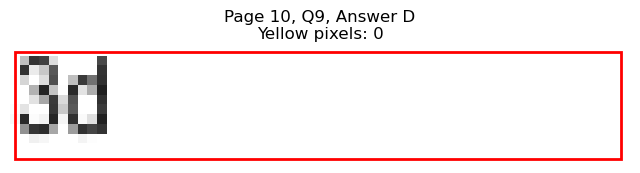


Page 10, Q9 - Selected Answer: A (based on yellow pixel count)




Page 10, Q10 - A: Detected box: x0=68.3, y0=722.2, x1=154.1, y1=733.3
Page 10, Q10, A: Yellow pixels: 0
Page 10, Q10, A: Total non-white pixels: 434
Page 10, Q10, A: Yellow percentage: 0.0%


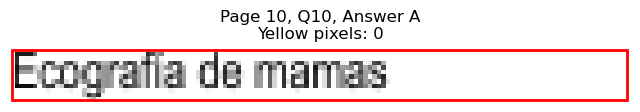

Page 10, Q10 - B: Detected box: x0=68.3, y0=734.8, x1=118.9, y1=745.9
Page 10, Q10, B: Yellow pixels: 0
Page 10, Q10, B: Total non-white pixels: 273
Page 10, Q10, B: Yellow percentage: 0.0%


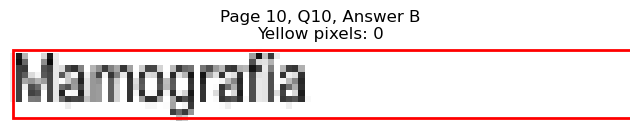

Page 10, Q10 - C: Detected box: x0=327.5, y0=722.2, x1=380.6, y1=733.3
Page 10, Q10, C: Yellow pixels: 949
Page 10, Q10, C: Total non-white pixels: 1248
Page 10, Q10, C: Yellow percentage: 76.0%


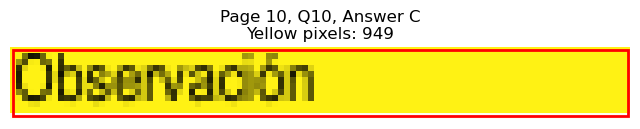

Page 10, Q10 - D: Detected box: x0=327.5, y0=734.8, x1=403.7, y1=745.9
Page 10, Q10, D: Yellow pixels: 0
Page 10, Q10, D: Total non-white pixels: 395
Page 10, Q10, D: Yellow percentage: 0.0%


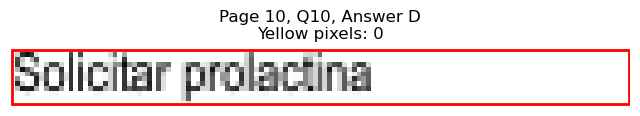


Page 10, Q10 - Selected Answer: C (based on yellow pixel count)





Page 11: Found 1 questions
Page 11, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=236.3, y1=114.8
Page 11, Q1, A: Yellow pixels: 1972
Page 11, Q1, A: Total non-white pixels: 2568
Page 11, Q1, A: Yellow percentage: 76.8%


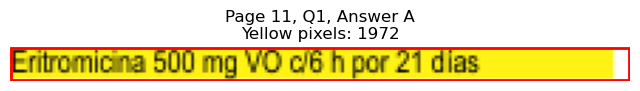

Page 11, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=236.8, y1=127.4
Page 11, Q1, B: Yellow pixels: 0
Page 11, Q1, B: Total non-white pixels: 762
Page 11, Q1, B: Yellow percentage: 0.0%


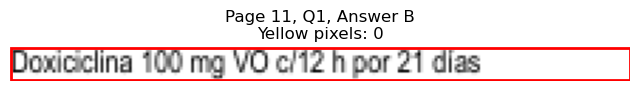

Page 11, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=513.5, y1=114.8
Page 11, Q1, C: Yellow pixels: 0
Page 11, Q1, C: Total non-white pixels: 878
Page 11, Q1, C: Yellow percentage: 0.0%


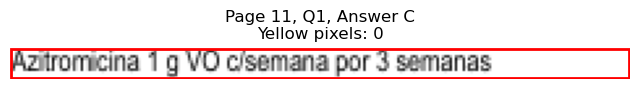

Page 11, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=507.7, y1=127.4
Page 11, Q1, D: Yellow pixels: 0
Page 11, Q1, D: Total non-white pixels: 867
Page 11, Q1, D: Yellow percentage: 0.0%


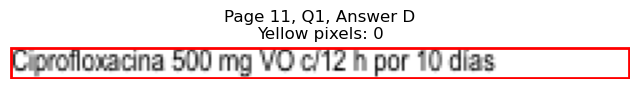


Page 11, Q1 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Puérpera mediata de 33 años, acude por present...
1   El grosor endometrial alcanza casi 12 mm al mo...
2   En el contexto de una hemorragia obstétrica po...
3   Segundigesta de 32 semanas, antecedente de ces...
4   Mujer de 19 años, con úlcera genital indolora ...
..                                                ...
95  Mujer de 34 años, acude por dolor pélvico de i...
96  Primigesta de 41 semanas, acude a control pren...
97  Luego de atender un parto, Ud. advierte un des...
98  Mujer de 32 años asintomática que acude por ch...
99  Adolescente de 15 años, que tuvo parto por ces...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                         Drenaje quirúrgico   
1                                    Estriol   
2            Sinequias de la cavidad uterina   
3                      Cesárea de emergencia   
4                                    Sífilis   
..                                       ...   
95                  Cáncer de ovario derecho   
96                     Cesárea de emergencia   
97                                        3a   
98                        Ecografía de mamas   
99  Eritromicina 500 mg VO c/6 h por 21 días   

                                     option_B  \
0                     Rotación de antibiótico   
1                                          LH   
2               Necrosis isquémica del cérvix   
3   Evolución del trabajo de parto espontáneo   
4                                  Chancroide   
..                                        ...   
95        Quiste de ovario a pediculo torcido   
96              Inducción de trabajo de parto   
97                                         3b   
98                                 Mamografía   
99   Doxiciclina 100 mg VO c/12 h por 21 días   

                                      option_C  \
0                             Compresas tibias   
1                                 Progesterona   
2        Riesgo aumentado de embarazo ectópico   
3                Tocólisis más neuroprotección   
4                                       Herpes   
..                                         ...   
95                        Plastron apendicular   
96              Vigilancia fetal cada 72 horas   
97                                          3c   
98                                 Observación   
99  Azitromicina 1 g VO c/semana por 3 semanas   

                                       option_D  
0                  Extracción vigorosa de leche  
1                                      Inhibina  
2               Aumento de tamaño del istmocele  
3                     Tocólisis más corticoides  
4                            Molusco contagioso  
..                                          ...  
95                  Absceso tuboovárico derecho  
96                     Cesárea a las 42 semanas  
97                                           3d  
98                         Solicitar prolactina  
99  Ciprofloxacina 500 mg VO c/12 h por 10 días  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               A
1               B
2               A
3               D
4               A
..            ...
95              D
96              B
97              A
98              C
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   Puérpera mediata de 33 años, acude por present...   
1   El grosor endometrial alcanza casi 12 mm al mo...   
2   En el contexto de una hemorragia obstétrica po...   
3   Segundigesta de 32 semanas, antecedente de ces...   
4   Mujer de 19 años, con úlcera genital indolora ...   
..                                                ...   
95  Mujer de 34 años, acude por dolor pélvico de i...   
96  Primigesta de 41 semanas, acude a control pren...   
97  Luego de atender un parto, Ud. advierte un des...   
98  Mujer de 32 años asintomática que acude por ch...   
99  Adolescente de 15 años, que tuvo parto por ces...   

                                    option_A  \
0                         Drenaje quirúrgico   
1                                    Estriol   
2            Sinequias de la cavidad uterina   
3                      Cesárea de emergencia   
4                                    Sífilis   
..                                       ...   
95                  Cáncer de ovario derecho   
96                     Cesárea de emergencia   
97                                        3a   
98                        Ecografía de mamas   
99  Eritromicina 500 mg VO c/6 h por 21 días   

                                     option_B  \
0                     Rotación de antibiótico   
1                                          LH   
2               Necrosis isquémica del cérvix   
3   Evolución del trabajo de parto espontáneo   
4                                  Chancroide   
..                                        ...   
95        Quiste de ovario a pediculo torcido   
96              Inducción de trabajo de parto   
97                                         3b   
98                                 Mamografía   
99   Doxiciclina 100 mg VO c/12 h por 21 días   

                                      option_C  \
0                             Compresas tibias   
1                                 Progesterona   
2        Riesgo aumentado de embarazo ectópico   
3                Tocólisis más neuroprotección   
4                                       Herpes   
..                                         ...   
95                        Plastron apendicular   
96              Vigilancia fetal cada 72 horas   
97                                          3c   
98                                 Observación   
99  Azitromicina 1 g VO c/semana por 3 semanas   

                                       option_D correct_answer  
0                  Extracción vigorosa de leche              A  
1                                      Inhibina              B  
2               Aumento de tamaño del istmocele              A  
3                     Tocólisis más corticoides              D  
4                            Molusco contagioso              A  
..                                          ...            ...  
95                  Absceso tuboovárico derecho              D  
96                     Cesárea a las 42 semanas              B  
97                                           3d              A  
98                         Solicitar prolactina              C  
99  Ciprofloxacina 500 mg VO c/12 h por 10 días              A  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Documents/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2025/GINECOLOGIA Y OBSTETRICIA.csv
